# Сравнение обучения GPT-2 с обычными и каузальными эмбеддингами

В этом разделе мы сравним динамику обучения двух моделей GPT-2:
- **GPT-2 с обычными эмбеддингами** (embedding слой стандартный, остальная модель не обучена)
- **GPT-2 с каузальными эмбеддингами** (embedding слой инициализирован вашими предобученными каузальными эмбеддингами, остальная модель не обучена)

Используется 0.1% wikitext-2, логирование метрик через wandb, визуализация и сохранение чекпоинтов прямо в ноутбуке.  
**Вопрос:** сейчас метрики считаются только на train. Для корректного сравнения стоит добавить валидационный датасет и считать метрики и на нем.

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from datasets import load_dataset
import wandb
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# --- Гиперпараметры ---
BATCH_SIZE = 32  # Было 64, уменьшили для более стабильного градиента
MAX_LEN = 64
LOG_INTERVAL = 1
EPOCHS = 8  # Было 20, теперь меньше эпох для быстрой проверки
LEARNING_RATE = 1e-6  # Было 5e-5, теперь ниже для стабильности
DROPOUT_PROB = 0.1
WEIGHT_DECAY = 0.001   # L2 регуляризация
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'
CHECKPOINT_DIR = './checkpoints_gpt2_compare/'
EARLY_STOPPING_PATIENCE = 2
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --- W&B ---
wandb.init(project="gpt2_causal_vs_regular", name="gpt2_comparison", reinit=True)

In [2]:
class CausalEmbeddingModel(torch.nn.Module):
  def __init__(self, base_model, dropout_prob=DROPOUT_PROB):
    super().__init__()
    self.encoder = base_model
    self.dropout = torch.nn.Dropout(dropout_prob)

  def forward(self, input_ids, attention_mask):
    outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
    last_hidden = outputs.last_hidden_state
    mask = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
    summed = torch.sum(last_hidden * mask, 1)
    counts = torch.clamp(mask.sum(1), min=1e-9)
    embeddings = summed / counts
    embeddings = self.dropout(embeddings)
    embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings

In [3]:
# --- Датасет ---
train_dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train[:20%]')
val_dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='validation[:20%]')

# --- Фильтрация пустых строк (первичная) ---
train_dataset = train_dataset.filter(lambda example: example['text'] and not example['text'].isspace())
val_dataset = val_dataset.filter(lambda example: example['text'] and not example['text'].isspace())

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# --- Токенайзер ---
def encode(example):
    # Ensure padding token is set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=MAX_LEN)

# --- Применяем токенизацию ---
train_dataset = train_dataset.map(encode, batched=True, remove_columns=["text"])
val_dataset = val_dataset.map(encode, batched=True, remove_columns=["text"])

# --- Фильтрация пустых токенизированных сэмплов ---
def filter_empty_tokens(example):
    # Check if input_ids is non-empty. Since we pad to MAX_LEN, 
    # a truly empty result from the tokenizer is unlikely unless MAX_LEN=0,
    # but this check handles potential edge cases or issues with the tokenizer/padding.
    # A more robust check might be needed depending on tokenizer behavior for edge cases.
    # However, the error suggests some tensors *are* size 0 before stacking.
    # Let's check the attention mask sum, as padded tokens have mask 0.
    # If the sum is 0, it means no real tokens are present.
    return sum(example['attention_mask']) > 0

train_dataset = train_dataset.filter(filter_empty_tokens)
val_dataset = val_dataset.filter(filter_empty_tokens)

# --- Устанавливаем формат ---
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# --- Загрузчики данных (стандартный collate_fn) ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [4]:
# --- Модели ---
config = GPT2Config(attn_pdrop=DROPOUT_PROB, resid_pdrop=DROPOUT_PROB, embd_pdrop=DROPOUT_PROB)

# Обычная GPT-2: только embedding слой предобучен, остальное не обучено
regular_gpt2 = GPT2LMHeadModel(config)
regular_gpt2.transformer.wte.weight.data = GPT2LMHeadModel.from_pretrained('gpt2').transformer.wte.weight.data.clone()
regular_gpt2 = regular_gpt2.to(DEVICE)

# Каузальные эмбеддинги
causal_gpt2 = GPT2LMHeadModel(config)
state = torch.load('../models/causal_embeds.pth', map_location=DEVICE)
# Определяем embedding вес
if isinstance(state, dict):
    if 'embeddings' in state:
        embed_weight = state['embeddings']
    elif 'encoder.weight' in state:
        embed_weight = state['encoder.weight']
    else:
        wte_shape = causal_gpt2.transformer.wte.weight.shape
        for v in state.values():
            if isinstance(v, torch.Tensor) and v.shape == wte_shape:
                embed_weight = v
                break
        else:
            raise ValueError(f"Cannot find embedding weights in state dict, expected shape {wte_shape}")
elif isinstance(state, torch.Tensor):
    embed_weight = state
else:
    raise ValueError(f"Unexpected type for loaded state: {type(state)}")
# Копируем веса эмбеддингов
with torch.no_grad():
    causal_gpt2.transformer.wte.weight.data.copy_(embed_weight)
causal_gpt2 = causal_gpt2.to(DEVICE)

# --- Дополнительно: Полностью неинициализированная GPT-2 ---
# """
uninitialized_gpt2 = GPT2LMHeadModel(config) # Просто создаем из конфига
uninitialized_gpt2 = uninitialized_gpt2.to(DEVICE)
# """

# --- Оптимизаторы ---
optim_regular = torch.optim.AdamW(regular_gpt2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optim_causal  = torch.optim.AdamW(causal_gpt2.parameters(),  lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optim_uninitialized = torch.optim.AdamW(uninitialized_gpt2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Linear scheduler with warmup (20% warmup)
num_training_steps = EPOCHS * len(train_loader)
num_warmup_steps = int(0.2 * num_training_steps)  # 20% warmup
scheduler_regular = CosineAnnealingLR(optim_regular, T_max=num_training_steps)
scheduler_causal = CosineAnnealingLR(optim_causal, T_max=num_training_steps)
scheduler_uninitialized = CosineAnnealingLR(optim_uninitialized, T_max=num_training_steps)

In [5]:
# --- Метрики ---
import torch

def accuracy(preds, labels, attention_mask):
    preds = preds.argmax(-1)
    mask = attention_mask.bool()
    correct = (preds[mask] == labels[mask]).sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0


def top_k_accuracy(preds, labels, attention_mask, k=5):
    topk = preds.topk(k, dim=-1).indices
    mask = attention_mask.bool()
    correct = (topk[mask].eq(labels[mask].unsqueeze(-1))).any(-1).sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0


def evaluate(model, dataloader):
    model.eval()
    losses, accs, top5_accs = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = input_ids.clone()
            labels[attention_mask == 0] = -100

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits.detach().cpu()

            losses.append(loss.item())
            accs.append(accuracy(logits, labels.cpu(), attention_mask.cpu()))
            top5_accs.append(top_k_accuracy(logits, labels.cpu(), attention_mask.cpu(), k=5))
    return np.mean(losses), np.exp(np.mean(losses)), np.mean(accs), np.mean(top5_accs)

Starting training...
Starting training for regular model...
--- Starting training for regular ---


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


  Step: 0 | Batch: 1/149
    Train Loss: 22.1314 | Train PPL: 4088301092.7700
    Train Acc: 0.8329 | Train Top-5: 0.9618
    Val Loss:   22.4244 | Val PPL:   5480129057.8669
    Val Acc:    0.9239 | Val Top-5:   0.9769
    Grad Norm:  6.1086
  Step: 1 | Batch: 2/149
    Train Loss: 22.8145 | Train PPL: 8094782456.6850
    Train Acc: 0.9376 | Train Top-5: 0.9829
    Val Loss:   21.8085 | Val PPL:   2960155627.8983
    Val Acc:    0.9429 | Val Top-5:   0.9842
    Grad Norm:  6.0690
  Step: 1 | Batch: 2/149
    Train Loss: 22.8145 | Train PPL: 8094782456.6850
    Train Acc: 0.9376 | Train Top-5: 0.9829
    Val Loss:   21.8085 | Val PPL:   2960155627.8983
    Val Acc:    0.9429 | Val Top-5:   0.9842
    Grad Norm:  6.0690
  Step: 2 | Batch: 3/149
    Train Loss: 22.0040 | Train PPL: 3599101683.8944
    Train Acc: 0.9467 | Train Top-5: 0.9873
    Val Loss:   21.2141 | Val PPL:   1633686590.7041
    Val Acc:    0.9516 | Val Top-5:   0.9867
    Grad Norm:  6.0713
  Step: 2 | Batch: 3/149
   

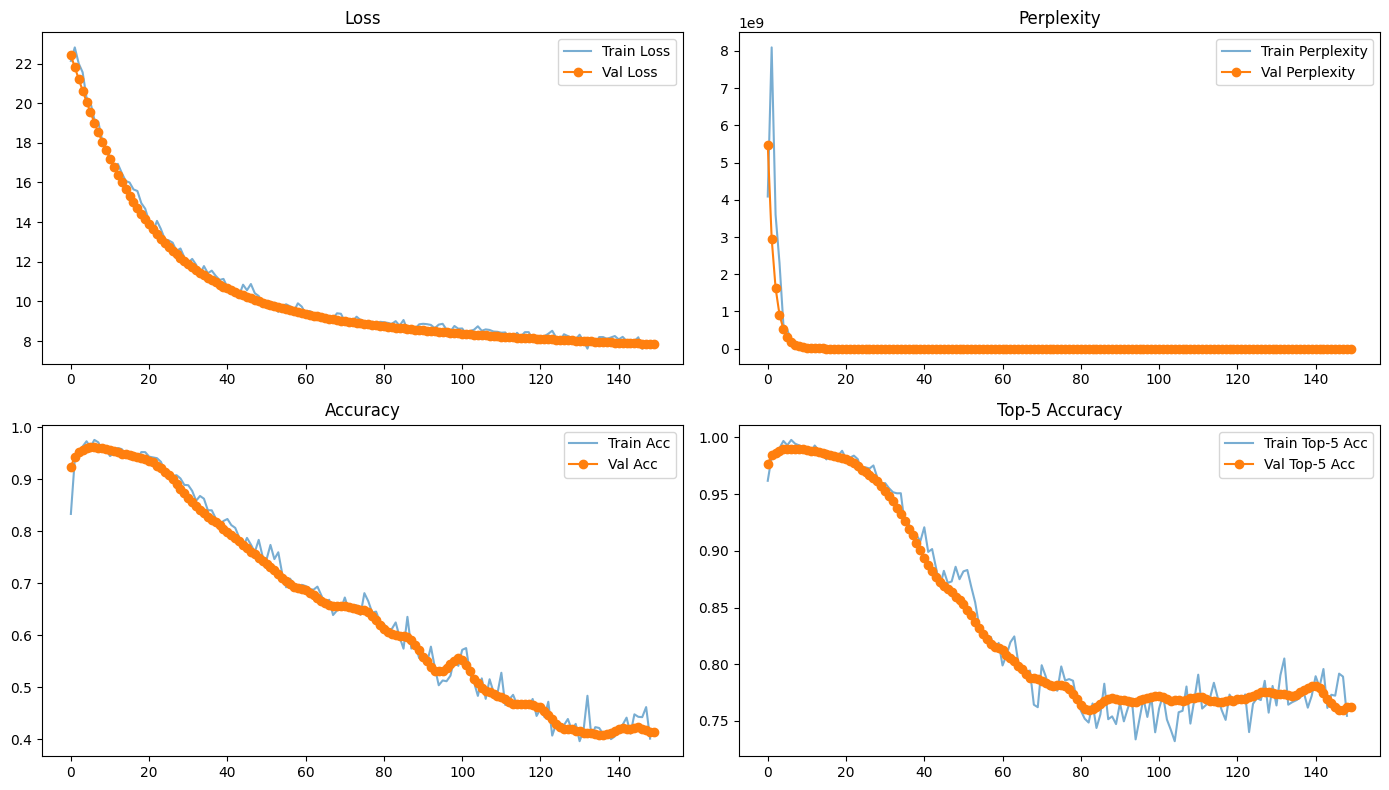

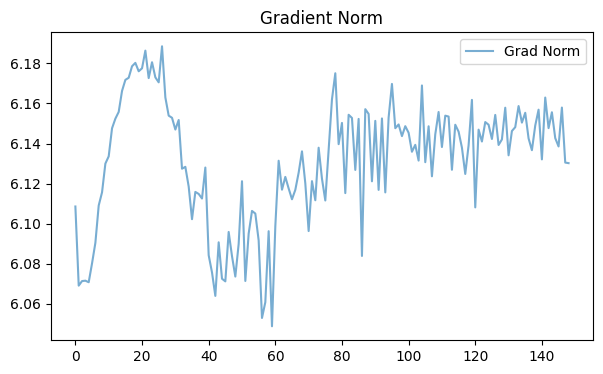

  Validation loss improved to 7.8535. Saving model checkpoint.
  Step: 149 | Batch: 1/149
    Train Loss: 8.0058 | Train PPL: 2998.4415
    Train Acc: 0.4523 | Train Top-5: 0.7937
    Val Loss:   7.8453 | Val PPL:   2553.7505
    Val Acc:    0.4106 | Val Top-5:   0.7637
    Grad Norm:  6.1124
  Step: 149 | Batch: 1/149
    Train Loss: 8.0058 | Train PPL: 2998.4415
    Train Acc: 0.4523 | Train Top-5: 0.7937
    Val Loss:   7.8453 | Val PPL:   2553.7505
    Val Acc:    0.4106 | Val Top-5:   0.7637
    Grad Norm:  6.1124
  Step: 150 | Batch: 2/149
    Train Loss: 7.6012 | Train PPL: 2000.6078
    Train Acc: 0.4093 | Train Top-5: 0.7650
    Val Loss:   7.8369 | Val PPL:   2532.3483
    Val Acc:    0.4088 | Val Top-5:   0.7652
    Grad Norm:  6.1228
  Step: 150 | Batch: 2/149
    Train Loss: 7.6012 | Train PPL: 2000.6078
    Train Acc: 0.4093 | Train Top-5: 0.7650
    Val Loss:   7.8369 | Val PPL:   2532.3483
    Val Acc:    0.4088 | Val Top-5:   0.7652
    Grad Norm:  6.1228
  Step: 151 |

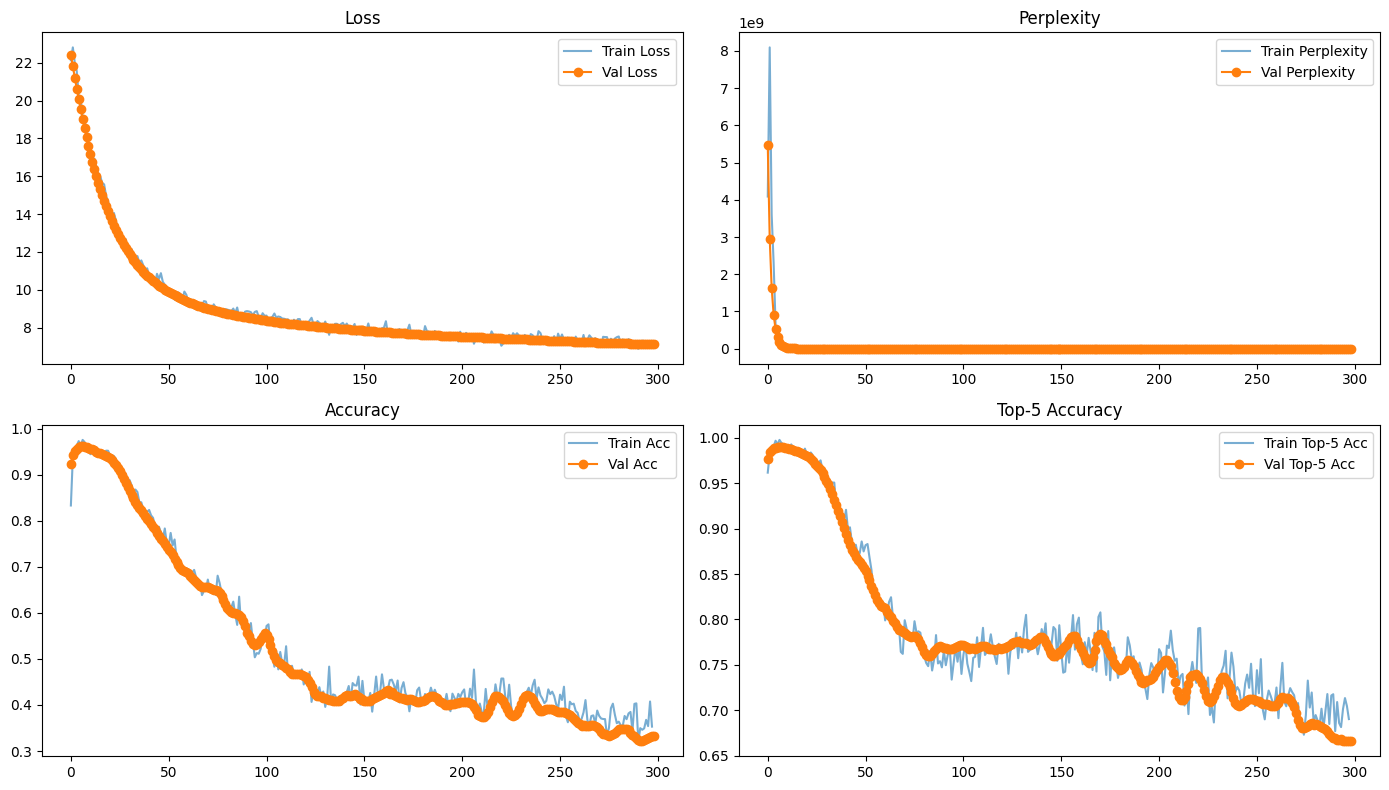

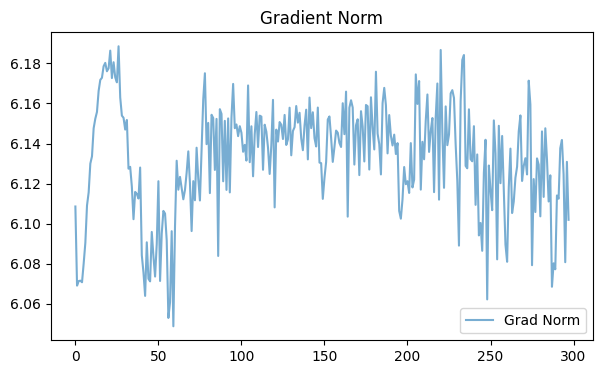

  Validation loss improved to 7.1285. Saving model checkpoint.
  Step: 298 | Batch: 1/149
    Train Loss: 7.4521 | Train PPL: 1723.4191
    Train Acc: 0.4140 | Train Top-5: 0.7515
    Val Loss:   7.1260 | Val PPL:   1243.9111
    Val Acc:    0.3316 | Val Top-5:   0.6665
    Grad Norm:  6.1182
  Step: 298 | Batch: 1/149
    Train Loss: 7.4521 | Train PPL: 1723.4191
    Train Acc: 0.4140 | Train Top-5: 0.7515
    Val Loss:   7.1260 | Val PPL:   1243.9111
    Val Acc:    0.3316 | Val Top-5:   0.6665
    Grad Norm:  6.1182
  Step: 299 | Batch: 2/149
    Train Loss: 7.3412 | Train PPL: 1542.5178
    Train Acc: 0.3994 | Train Top-5: 0.7102
    Val Loss:   7.1234 | Val PPL:   1240.7155
    Val Acc:    0.3312 | Val Top-5:   0.6660
    Grad Norm:  6.1071
  Step: 299 | Batch: 2/149
    Train Loss: 7.3412 | Train PPL: 1542.5178
    Train Acc: 0.3994 | Train Top-5: 0.7102
    Val Loss:   7.1234 | Val PPL:   1240.7155
    Val Acc:    0.3312 | Val Top-5:   0.6660
    Grad Norm:  6.1071
  Step: 300 |

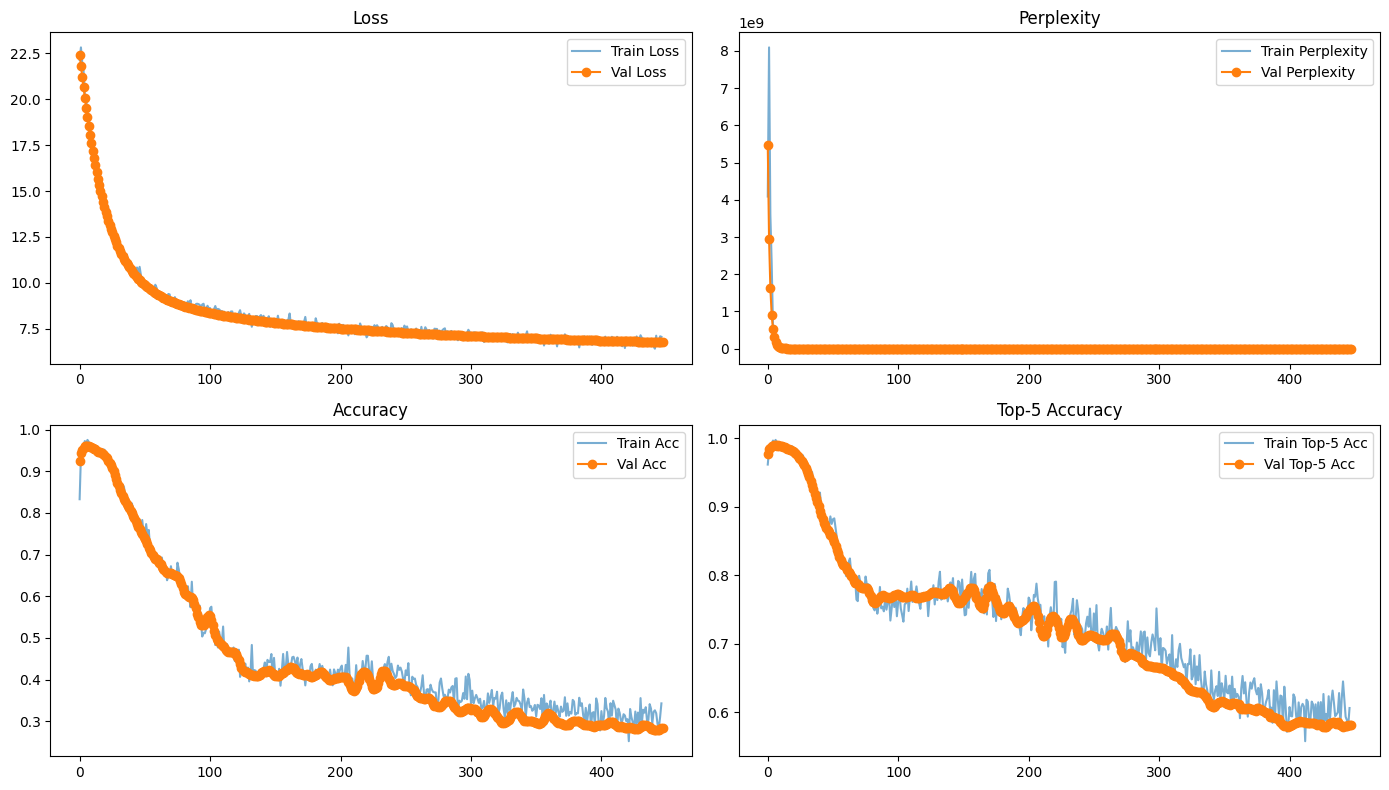

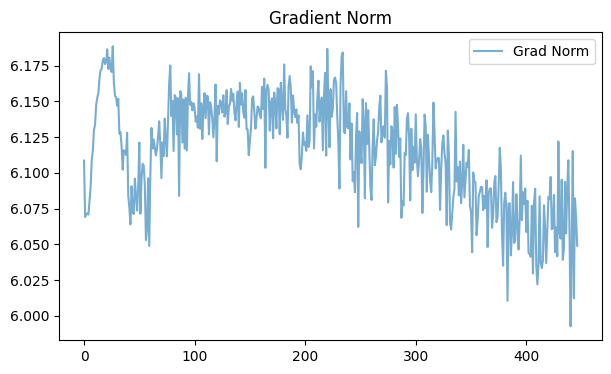

  Validation loss improved to 6.7829. Saving model checkpoint.
  Step: 447 | Batch: 1/149
    Train Loss: 7.1050 | Train PPL: 1218.0409
    Train Acc: 0.3346 | Train Top-5: 0.6386
    Val Loss:   6.7812 | Val PPL:   881.0941
    Val Acc:    0.2852 | Val Top-5:   0.5806
    Grad Norm:  6.0327
  Step: 448 | Batch: 2/149
    Train Loss: 6.7270 | Train PPL: 834.6219
    Train Acc: 0.2776 | Train Top-5: 0.5676
    Val Loss:   6.7796 | Val PPL:   879.7005
    Val Acc:    0.2847 | Val Top-5:   0.5798
    Grad Norm:  6.0685
  Step: 449 | Batch: 3/149
    Train Loss: 6.6779 | Train PPL: 794.6814
    Train Acc: 0.3137 | Train Top-5: 0.6149
    Val Loss:   6.7782 | Val PPL:   878.4584
    Val Acc:    0.2849 | Val Top-5:   0.5762
    Grad Norm:  6.0289
  Step: 450 | Batch: 4/149
    Train Loss: 6.9328 | Train PPL: 1025.3461
    Train Acc: 0.3125 | Train Top-5: 0.5838
    Val Loss:   6.7768 | Val PPL:   877.2371
    Val Acc:    0.2868 | Val Top-5:   0.5769
    Grad Norm:  6.0453
  Step: 451 | Batch

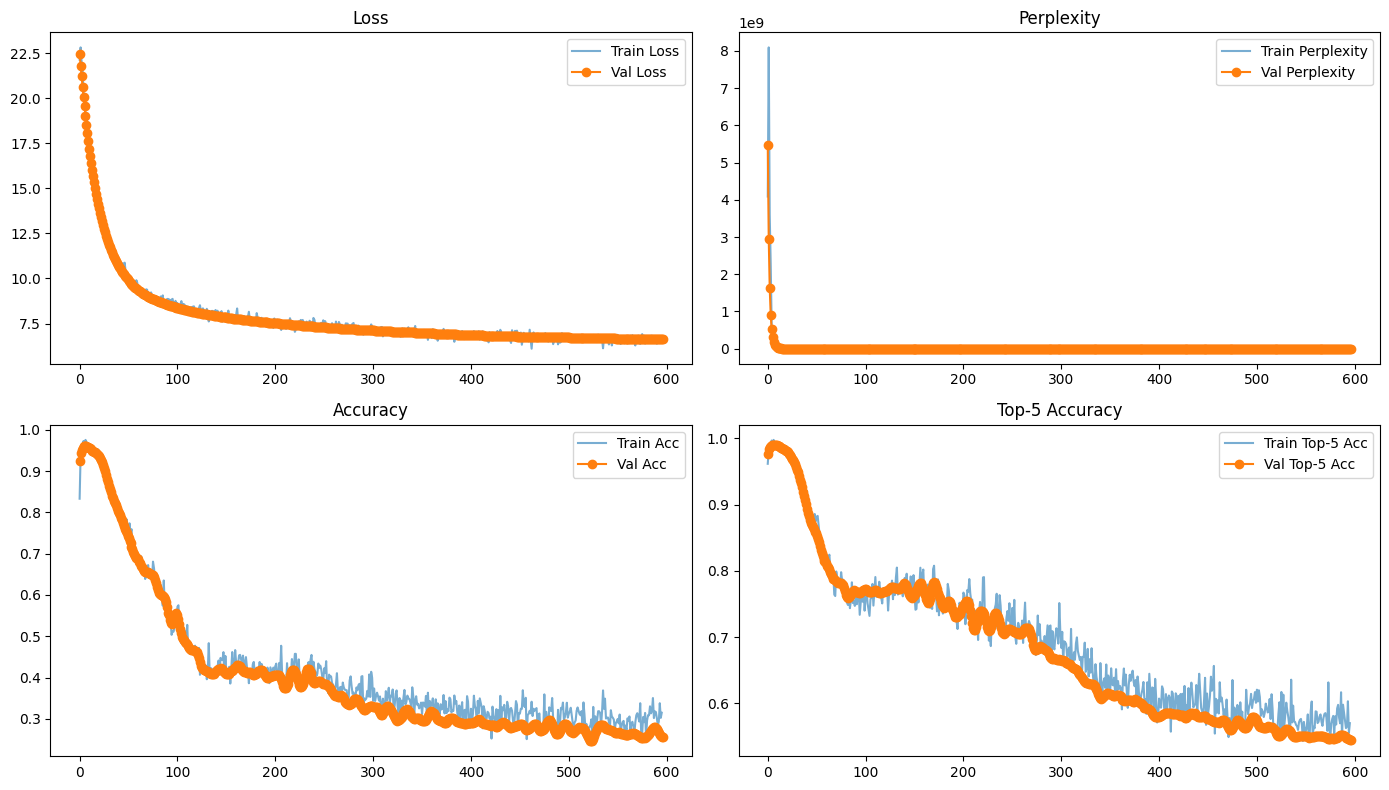

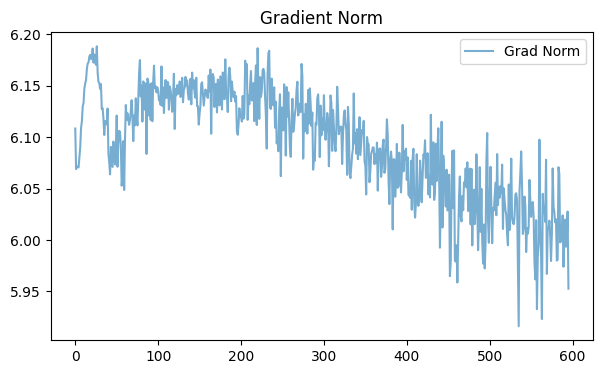

  Validation loss improved to 6.6355. Saving model checkpoint.
  Step: 596 | Batch: 1/149
    Train Loss: 6.8540 | Train PPL: 947.6505
    Train Acc: 0.3234 | Train Top-5: 0.6351
    Val Loss:   6.6346 | Val PPL:   760.9705
    Val Acc:    0.2537 | Val Top-5:   0.5454
    Grad Norm:  5.9487
  Step: 597 | Batch: 2/149
    Train Loss: 6.7115 | Train PPL: 821.7642
    Train Acc: 0.2775 | Train Top-5: 0.5927
    Val Loss:   6.6336 | Val PPL:   760.2271
    Val Acc:    0.2533 | Val Top-5:   0.5451
    Grad Norm:  5.9672
  Step: 598 | Batch: 3/149
    Train Loss: 6.6004 | Train PPL: 735.3549
    Train Acc: 0.3289 | Train Top-5: 0.6015
    Val Loss:   6.6327 | Val PPL:   759.5148
    Val Acc:    0.2532 | Val Top-5:   0.5451
    Grad Norm:  6.0302
  Step: 599 | Batch: 4/149
    Train Loss: 6.5428 | Train PPL: 694.2234
    Train Acc: 0.2566 | Train Top-5: 0.5510
    Val Loss:   6.6319 | Val PPL:   758.9476
    Val Acc:    0.2533 | Val Top-5:   0.5459
    Grad Norm:  5.9951
  Step: 600 | Batch: 

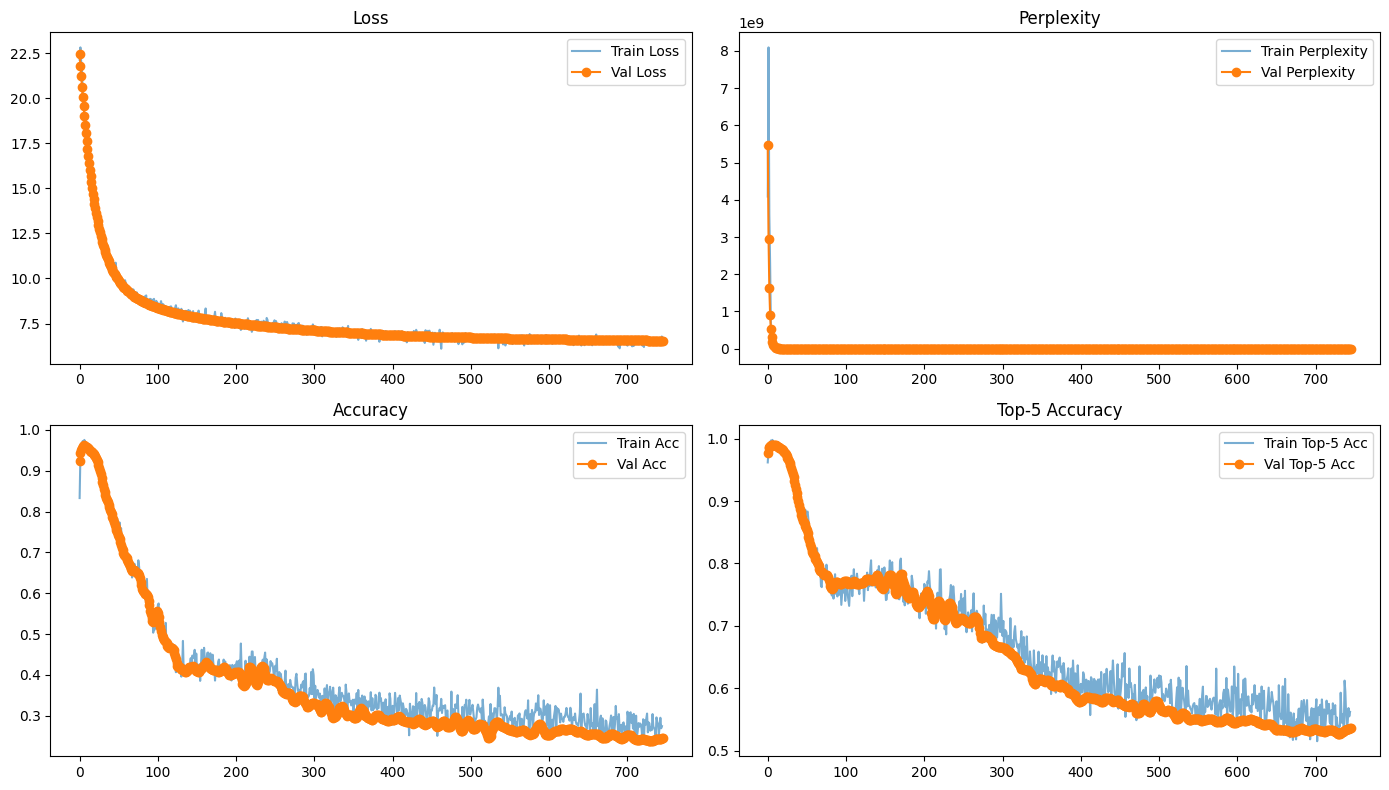

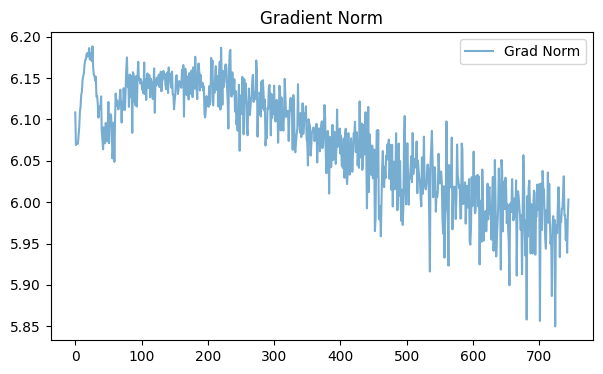

  Validation loss improved to 6.5541. Saving model checkpoint.
  Step: 745 | Batch: 1/149
    Train Loss: 6.7802 | Train PPL: 880.2385
    Train Acc: 0.3041 | Train Top-5: 0.6067
    Val Loss:   6.5538 | Val PPL:   701.9122
    Val Acc:    0.2448 | Val Top-5:   0.5363
    Grad Norm:  5.9753
  Step: 746 | Batch: 2/149
    Train Loss: 6.5427 | Train PPL: 694.1562
    Train Acc: 0.2790 | Train Top-5: 0.5649
    Val Loss:   6.5535 | Val PPL:   701.6758
    Val Acc:    0.2441 | Val Top-5:   0.5361
    Grad Norm:  5.9825
  Step: 747 | Batch: 3/149
    Train Loss: 6.4493 | Train PPL: 632.2537
    Train Acc: 0.2874 | Train Top-5: 0.5749
    Val Loss:   6.5531 | Val PPL:   701.3821
    Val Acc:    0.2430 | Val Top-5:   0.5360
    Grad Norm:  5.9588
  Step: 748 | Batch: 4/149
    Train Loss: 6.5776 | Train PPL: 718.8392
    Train Acc: 0.2927 | Train Top-5: 0.6036
    Val Loss:   6.5528 | Val PPL:   701.2012
    Val Acc:    0.2432 | Val Top-5:   0.5360
    Grad Norm:  6.0029
  Step: 749 | Batch: 

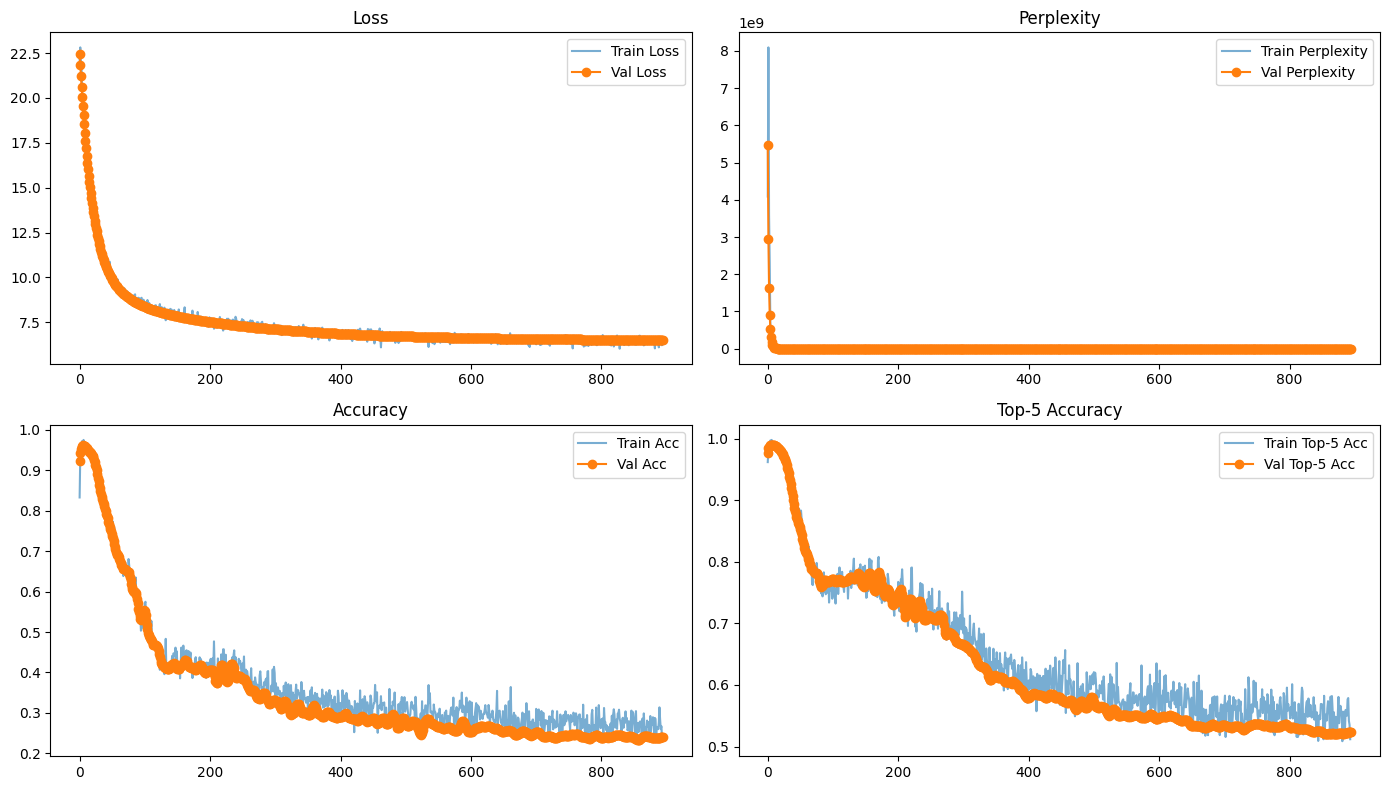

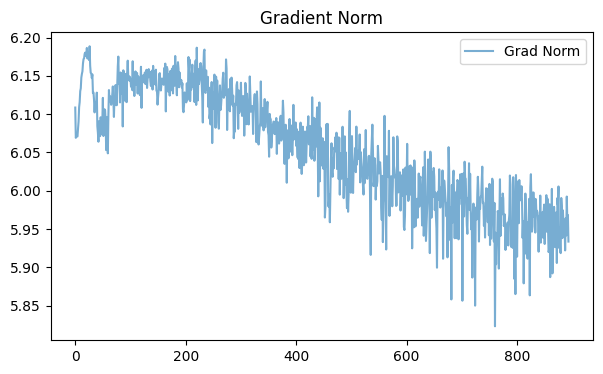

  Validation loss improved to 6.5125. Saving model checkpoint.
  Step: 894 | Batch: 1/149
    Train Loss: 6.4864 | Train PPL: 656.1326
    Train Acc: 0.3063 | Train Top-5: 0.6171
    Val Loss:   6.5123 | Val PPL:   673.3440
    Val Acc:    0.2395 | Val Top-5:   0.5241
    Grad Norm:  5.9737
  Step: 895 | Batch: 2/149
    Train Loss: 6.4659 | Train PPL: 642.8126
    Train Acc: 0.2660 | Train Top-5: 0.5626
    Val Loss:   6.5121 | Val PPL:   673.2127
    Val Acc:    0.2398 | Val Top-5:   0.5243
    Grad Norm:  5.9727
  Step: 896 | Batch: 3/149
    Train Loss: 6.5383 | Train PPL: 691.0916
    Train Acc: 0.2872 | Train Top-5: 0.5745
    Val Loss:   6.5119 | Val PPL:   673.0837
    Val Acc:    0.2406 | Val Top-5:   0.5246
    Grad Norm:  5.9646
  Step: 897 | Batch: 4/149
    Train Loss: 6.4157 | Train PPL: 611.3834
    Train Acc: 0.2898 | Train Top-5: 0.5657
    Val Loss:   6.5118 | Val PPL:   673.0096
    Val Acc:    0.2414 | Val Top-5:   0.5250
    Grad Norm:  5.9687
  Step: 898 | Batch: 

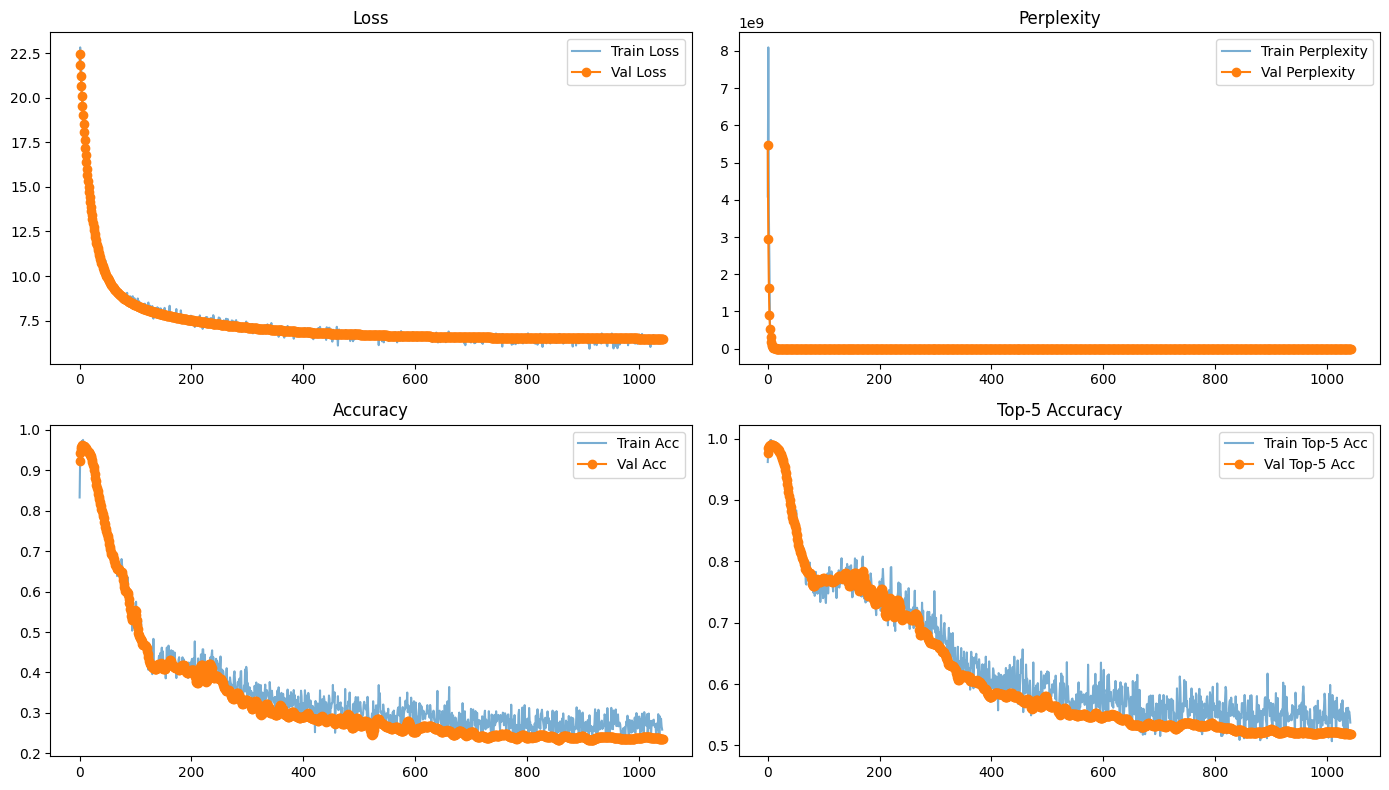

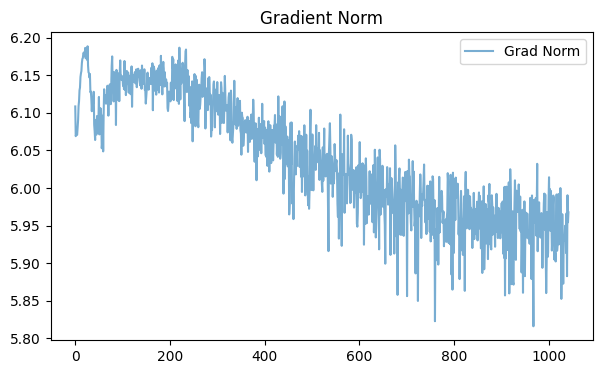

  Validation loss improved to 6.4973. Saving model checkpoint.
  Step: 1043 | Batch: 1/149
    Train Loss: 6.5560 | Train PPL: 703.4739
    Train Acc: 0.3051 | Train Top-5: 0.6445
    Val Loss:   6.4972 | Val PPL:   663.3094
    Val Acc:    0.2358 | Val Top-5:   0.5187
    Grad Norm:  5.9622
  Step: 1044 | Batch: 2/149
    Train Loss: 6.5367 | Train PPL: 689.9948
    Train Acc: 0.2803 | Train Top-5: 0.5456
    Val Loss:   6.4972 | Val PPL:   663.2844
    Val Acc:    0.2356 | Val Top-5:   0.5185
    Grad Norm:  5.9803
  Step: 1045 | Batch: 3/149
    Train Loss: 6.3296 | Train PPL: 560.9147
    Train Acc: 0.2846 | Train Top-5: 0.5543
    Val Loss:   6.4972 | Val PPL:   663.2572
    Val Acc:    0.2355 | Val Top-5:   0.5185
    Grad Norm:  5.9578
  Step: 1046 | Batch: 4/149
    Train Loss: 6.4770 | Train PPL: 650.0209
    Train Acc: 0.3220 | Train Top-5: 0.6200
    Val Loss:   6.4972 | Val PPL:   663.2488
    Val Acc:    0.2353 | Val Top-5:   0.5185
    Grad Norm:  5.9174
  Step: 1047 | Ba

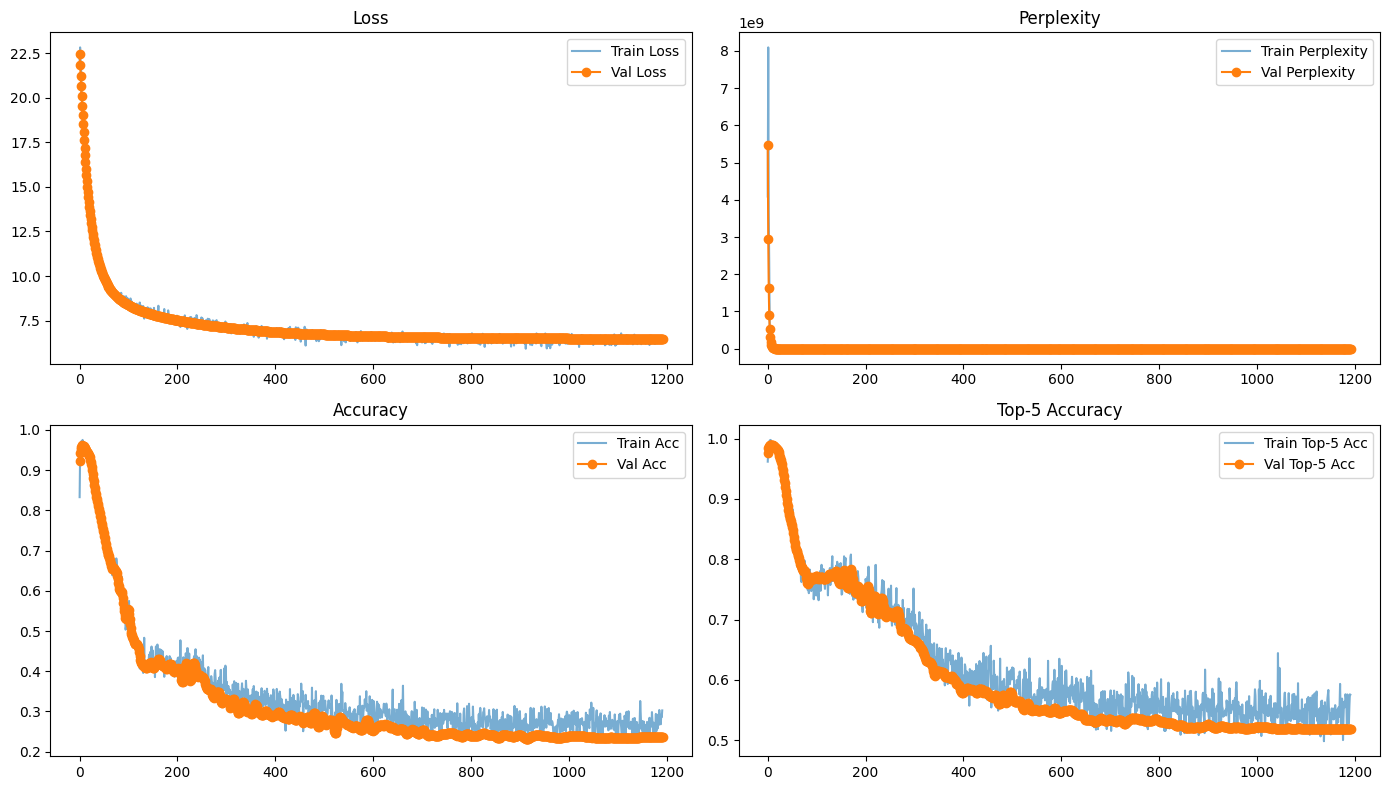

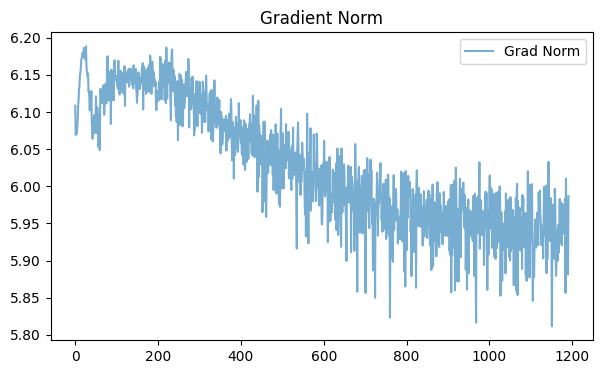

  Validation loss improved to 6.4952. Saving model checkpoint.
--- Finished training for regular ---
Finished training for regular model.
Starting training for causal model...
--- Starting training for causal ---
  Step: 0 | Batch: 1/149
    Train Loss: 23.2356 | Train PPL: 12333608799.6069
    Train Acc: 0.8611 | Train Top-5: 0.9773
    Val Loss:   22.7226 | Val PPL:   7383977500.8214
    Val Acc:    0.9205 | Val Top-5:   0.9902
    Grad Norm:  6.0698
  Step: 1 | Batch: 2/149
    Train Loss: 23.1837 | Train PPL: 11709834011.0072
    Train Acc: 0.9038 | Train Top-5: 0.9903
    Val Loss:   22.0789 | Val PPL:   3879094836.7731
    Val Acc:    0.9299 | Val Top-5:   0.9910
    Grad Norm:  6.0297
  Step: 2 | Batch: 3/149
    Train Loss: 22.1063 | Train PPL: 3987095923.9394
    Train Acc: 0.9340 | Train Top-5: 0.9909
    Val Loss:   21.4501 | Val PPL:   2068537050.0376
    Val Acc:    0.9370 | Val Top-5:   0.9914
    Grad Norm:  6.0362
  Step: 3 | Batch: 4/149
    Train Loss: 22.0241 | Train

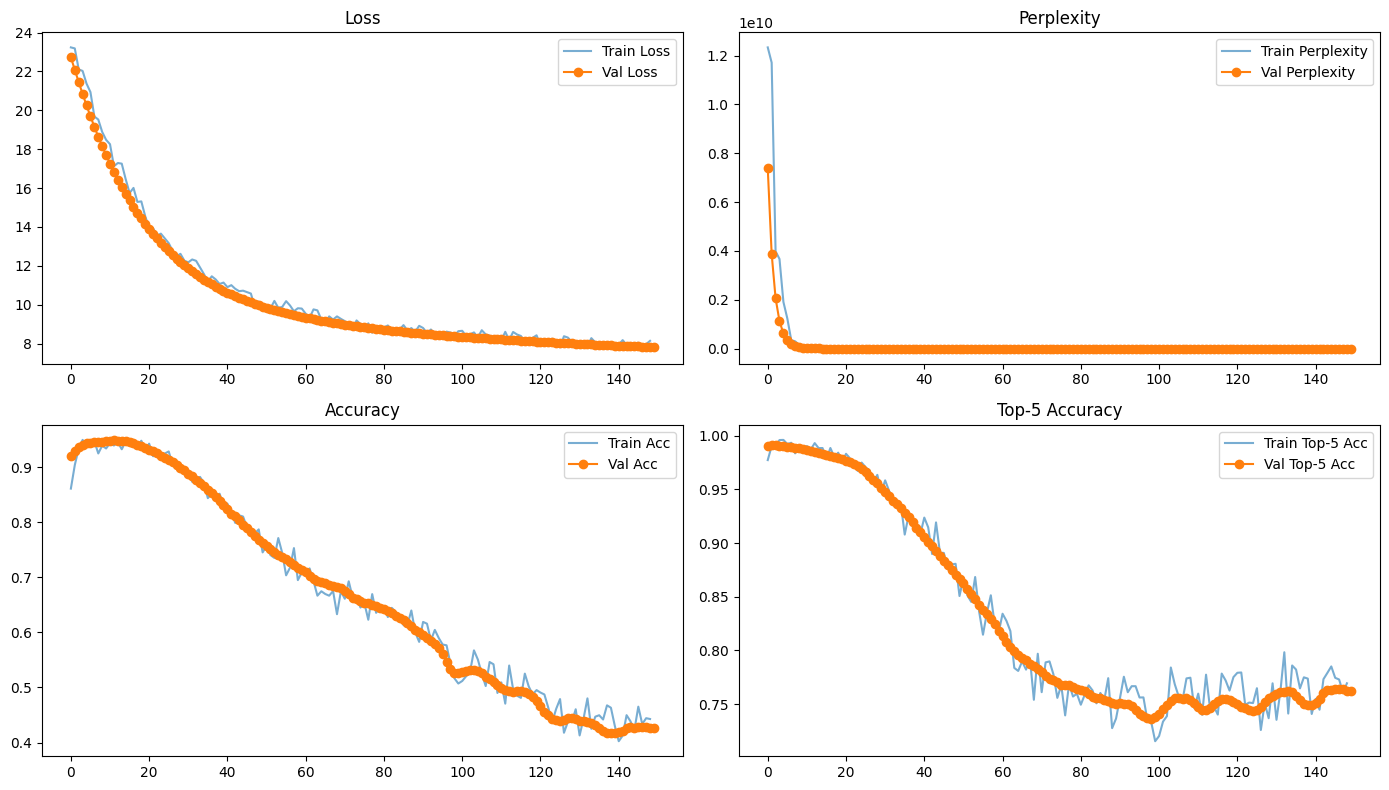

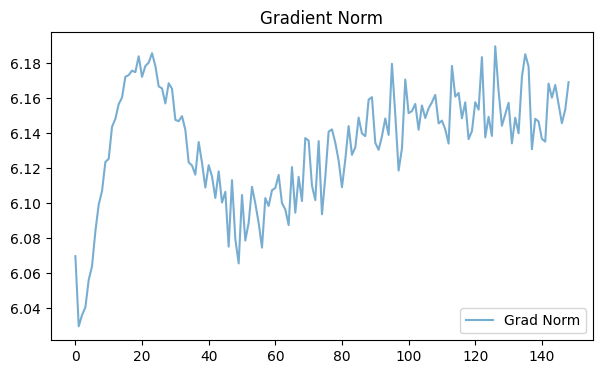

  Validation loss improved to 7.8308. Saving model checkpoint.
  Step: 149 | Batch: 1/149
    Train Loss: 8.0198 | Train PPL: 3040.5320
    Train Acc: 0.4917 | Train Top-5: 0.8007
    Val Loss:   7.8228 | Val PPL:   2496.7804
    Val Acc:    0.4192 | Val Top-5:   0.7595
    Grad Norm:  6.1614
  Step: 150 | Batch: 2/149
    Train Loss: 8.0967 | Train PPL: 3283.4724
    Train Acc: 0.4417 | Train Top-5: 0.7760
    Val Loss:   7.8150 | Val PPL:   2477.5733
    Val Acc:    0.4136 | Val Top-5:   0.7574
    Grad Norm:  6.1393
  Step: 151 | Batch: 3/149
    Train Loss: 8.0687 | Train PPL: 3192.9630
    Train Acc: 0.4226 | Train Top-5: 0.7545
    Val Loss:   7.8085 | Val PPL:   2461.5013
    Val Acc:    0.4095 | Val Top-5:   0.7549
    Grad Norm:  6.1559
  Step: 152 | Batch: 4/149
    Train Loss: 7.7405 | Train PPL: 2299.6920
    Train Acc: 0.4364 | Train Top-5: 0.7700
    Val Loss:   7.8014 | Val PPL:   2444.0421
    Val Acc:    0.4083 | Val Top-5:   0.7541
    Grad Norm:  6.1635
  Step: 153 |

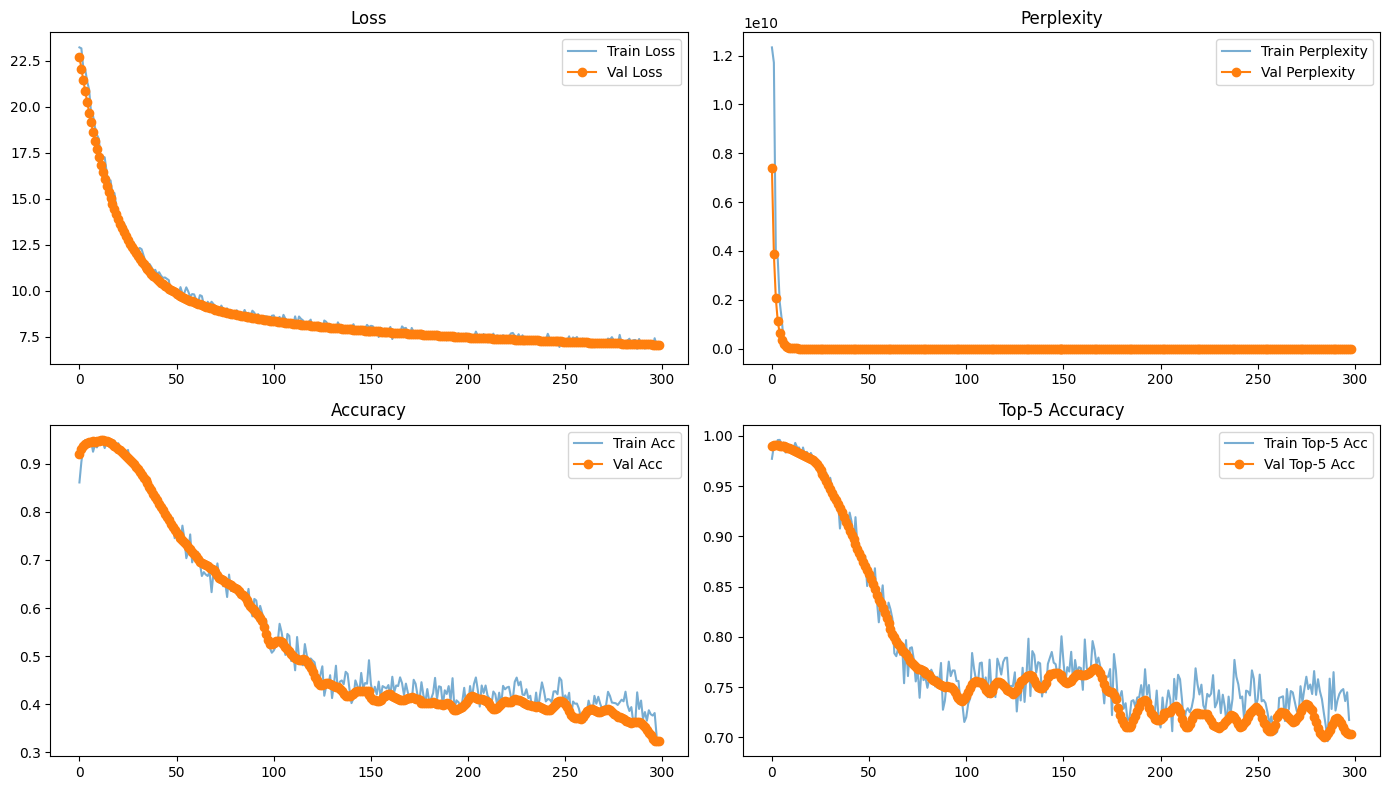

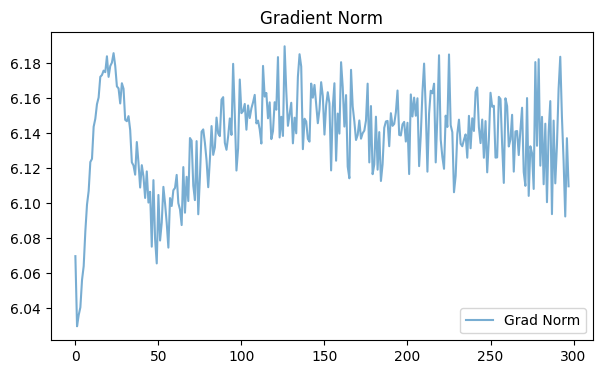

  Validation loss improved to 7.0731. Saving model checkpoint.
  Step: 298 | Batch: 1/149
    Train Loss: 7.3880 | Train PPL: 1616.5378
    Train Acc: 0.4096 | Train Top-5: 0.7502
    Val Loss:   7.0700 | Val PPL:   1176.0955
    Val Acc:    0.3244 | Val Top-5:   0.7028
    Grad Norm:  6.1048
  Step: 299 | Batch: 2/149
    Train Loss: 6.9905 | Train PPL: 1086.3178
    Train Acc: 0.3544 | Train Top-5: 0.7249
    Val Loss:   7.0670 | Val PPL:   1172.5799
    Val Acc:    0.3261 | Val Top-5:   0.7022
    Grad Norm:  6.1209
  Step: 300 | Batch: 3/149
    Train Loss: 7.1728 | Train PPL: 1303.4695
    Train Acc: 0.3481 | Train Top-5: 0.7152
    Val Loss:   7.0638 | Val PPL:   1168.8682
    Val Acc:    0.3310 | Val Top-5:   0.7042
    Grad Norm:  6.1551
  Step: 301 | Batch: 4/149
    Train Loss: 7.0619 | Train PPL: 1166.6443
    Train Acc: 0.3399 | Train Top-5: 0.7329
    Val Loss:   7.0604 | Val PPL:   1164.9331
    Val Acc:    0.3369 | Val Top-5:   0.7062
    Grad Norm:  6.1068
  Step: 302 |

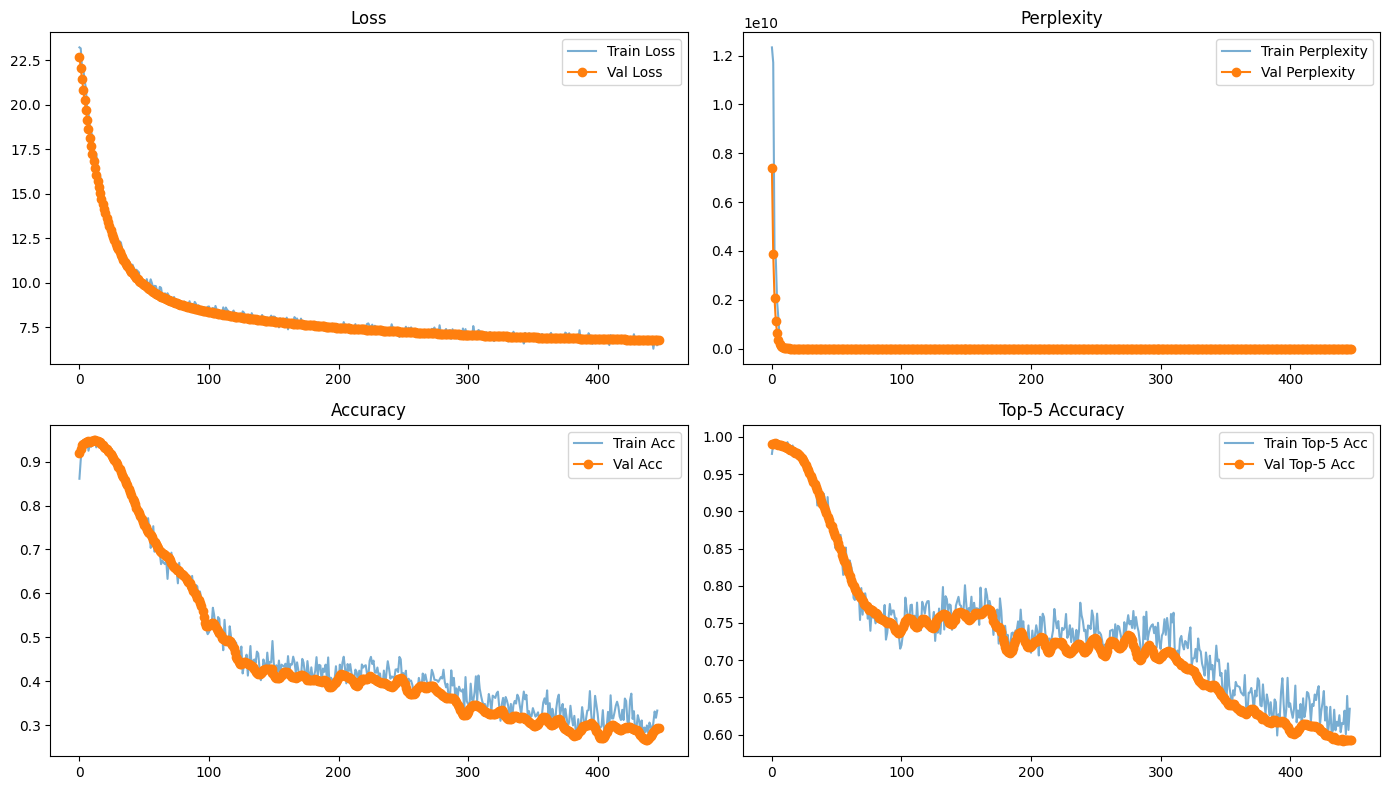

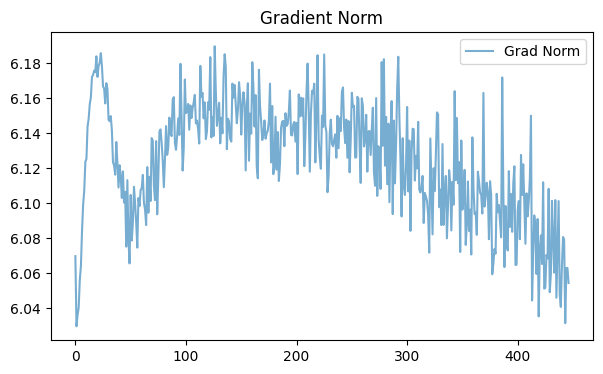

  Validation loss improved to 6.7645. Saving model checkpoint.
  Step: 447 | Batch: 1/149
    Train Loss: 6.9557 | Train PPL: 1049.1191
    Train Acc: 0.4162 | Train Top-5: 0.7343
    Val Loss:   6.7630 | Val PPL:   865.2461
    Val Acc:    0.2934 | Val Top-5:   0.5921
    Grad Norm:  6.0591
  Step: 448 | Batch: 2/149
    Train Loss: 6.3443 | Train PPL: 569.2547
    Train Acc: 0.3398 | Train Top-5: 0.6261
    Val Loss:   6.7616 | Val PPL:   864.0308
    Val Acc:    0.2916 | Val Top-5:   0.5905
    Grad Norm:  6.0196
  Step: 449 | Batch: 3/149
    Train Loss: 6.7264 | Train PPL: 834.1580
    Train Acc: 0.3048 | Train Top-5: 0.5976
    Val Loss:   6.7601 | Val PPL:   862.7363
    Val Acc:    0.2888 | Val Top-5:   0.5894
    Grad Norm:  6.1140
  Step: 450 | Batch: 4/149
    Train Loss: 6.8968 | Train PPL: 989.1347
    Train Acc: 0.3205 | Train Top-5: 0.6027
    Val Loss:   6.7589 | Val PPL:   861.6843
    Val Acc:    0.2855 | Val Top-5:   0.5888
    Grad Norm:  6.0444
  Step: 451 | Batch:

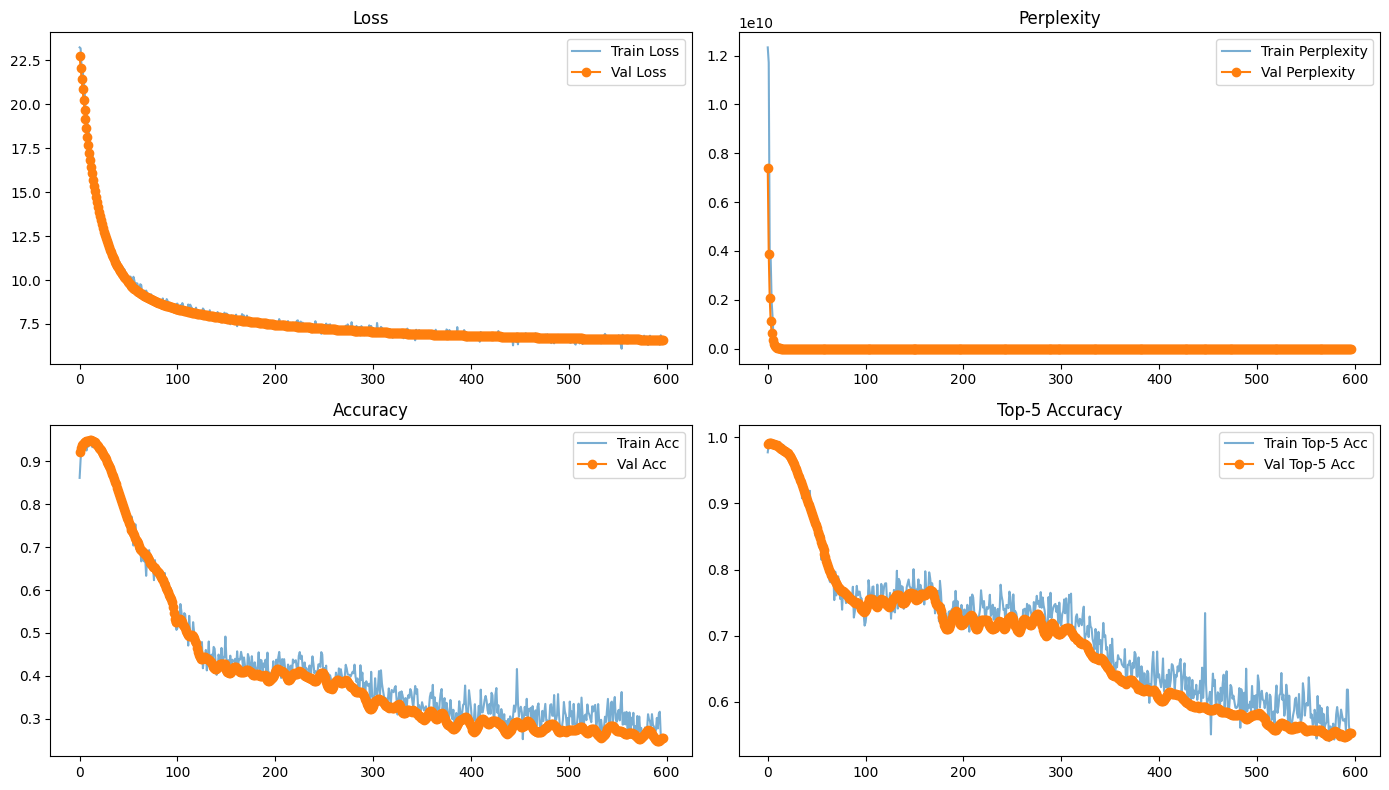

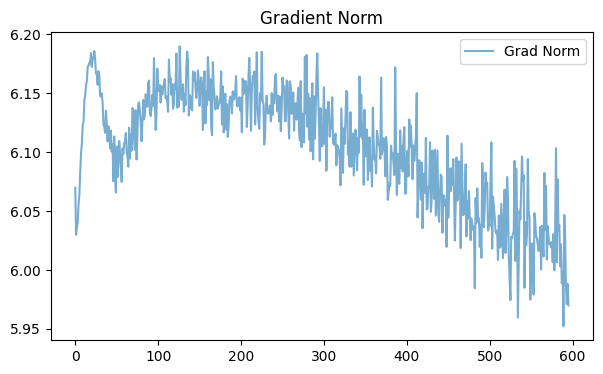

  Validation loss improved to 6.6036. Saving model checkpoint.
  Step: 596 | Batch: 1/149
    Train Loss: 6.5559 | Train PPL: 703.3488
    Train Acc: 0.3505 | Train Top-5: 0.6604
    Val Loss:   6.6032 | Val PPL:   737.4186
    Val Acc:    0.2578 | Val Top-5:   0.5543
    Grad Norm:  6.0129
  Step: 597 | Batch: 2/149
    Train Loss: 6.3772 | Train PPL: 588.2690
    Train Acc: 0.2965 | Train Top-5: 0.5984
    Val Loss:   6.6029 | Val PPL:   737.2249
    Val Acc:    0.2610 | Val Top-5:   0.5545
    Grad Norm:  5.9913
  Step: 598 | Batch: 3/149
    Train Loss: 6.6728 | Train PPL: 790.5904
    Train Acc: 0.2976 | Train Top-5: 0.5708
    Val Loss:   6.6025 | Val PPL:   736.9019
    Val Acc:    0.2641 | Val Top-5:   0.5561
    Grad Norm:  6.0067
  Step: 599 | Batch: 4/149
    Train Loss: 6.6543 | Train PPL: 776.1320
    Train Acc: 0.2942 | Train Top-5: 0.5876
    Val Loss:   6.6019 | Val PPL:   736.5147
    Val Acc:    0.2662 | Val Top-5:   0.5560
    Grad Norm:  6.0344
  Step: 600 | Batch: 

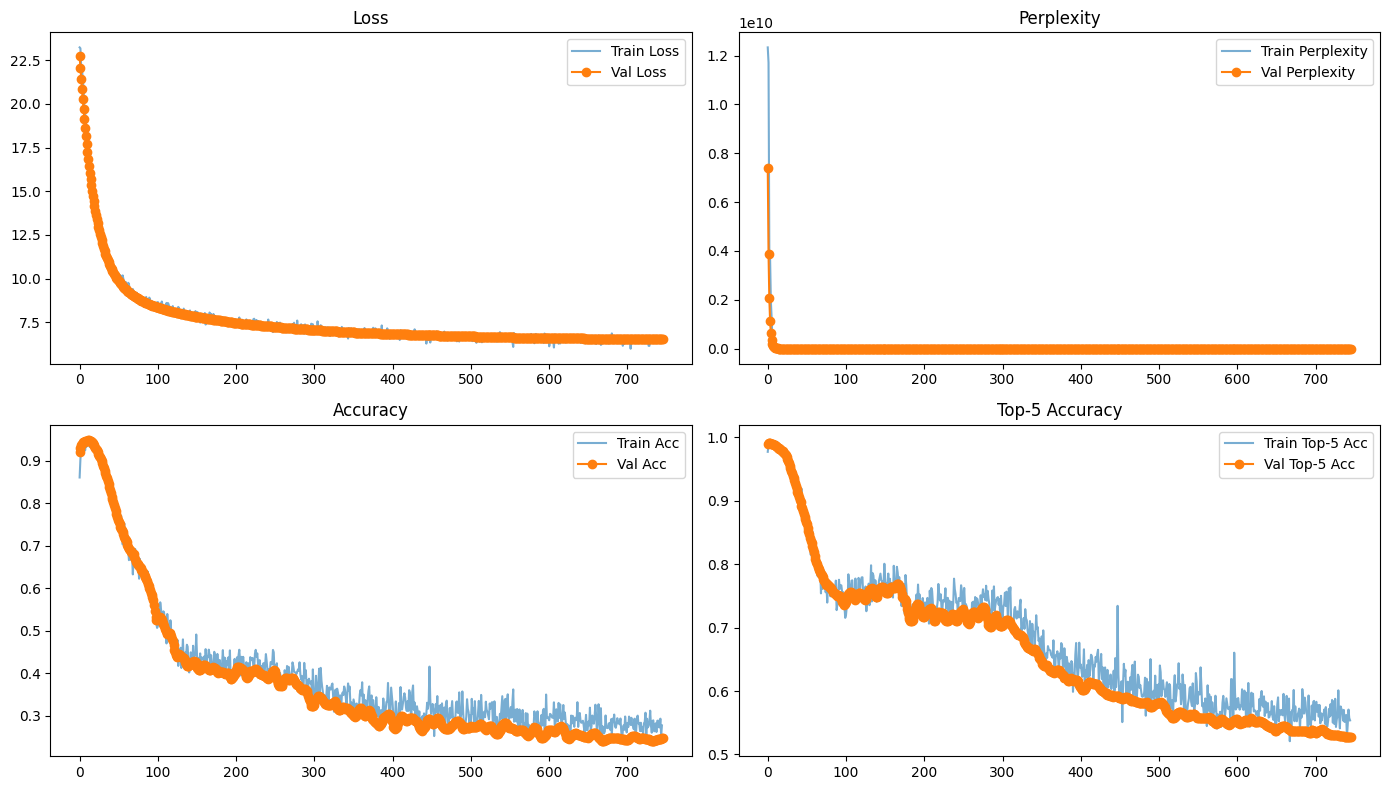

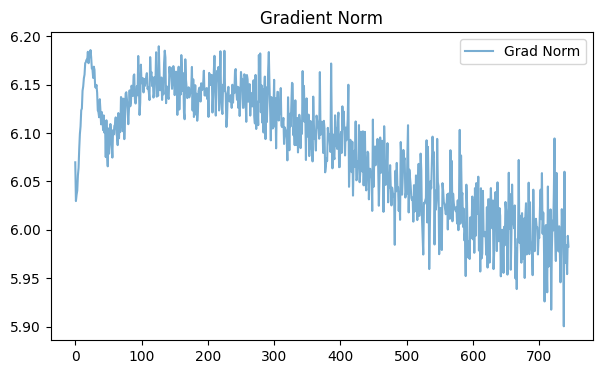

  Validation loss improved to 6.5200. Saving model checkpoint.
  Step: 745 | Batch: 1/149
    Train Loss: 6.3394 | Train PPL: 566.4754
    Train Acc: 0.3305 | Train Top-5: 0.6238
    Val Loss:   6.5194 | Val PPL:   678.2046
    Val Acc:    0.2472 | Val Top-5:   0.5281
    Grad Norm:  5.9516
  Step: 746 | Batch: 2/149
    Train Loss: 6.4588 | Train PPL: 638.3052
    Train Acc: 0.2821 | Train Top-5: 0.5509
    Val Loss:   6.5188 | Val PPL:   677.7684
    Val Acc:    0.2483 | Val Top-5:   0.5282
    Grad Norm:  5.9385
  Step: 747 | Batch: 3/149
    Train Loss: 6.4756 | Train PPL: 649.0973
    Train Acc: 0.2569 | Train Top-5: 0.5286
    Val Loss:   6.5183 | Val PPL:   677.4086
    Val Acc:    0.2485 | Val Top-5:   0.5285
    Grad Norm:  6.0047
  Step: 748 | Batch: 4/149
    Train Loss: 6.4028 | Train PPL: 603.5105
    Train Acc: 0.2806 | Train Top-5: 0.5654
    Val Loss:   6.5178 | Val PPL:   677.0627
    Val Acc:    0.2483 | Val Top-5:   0.5289
    Grad Norm:  5.9414
  Step: 749 | Batch: 

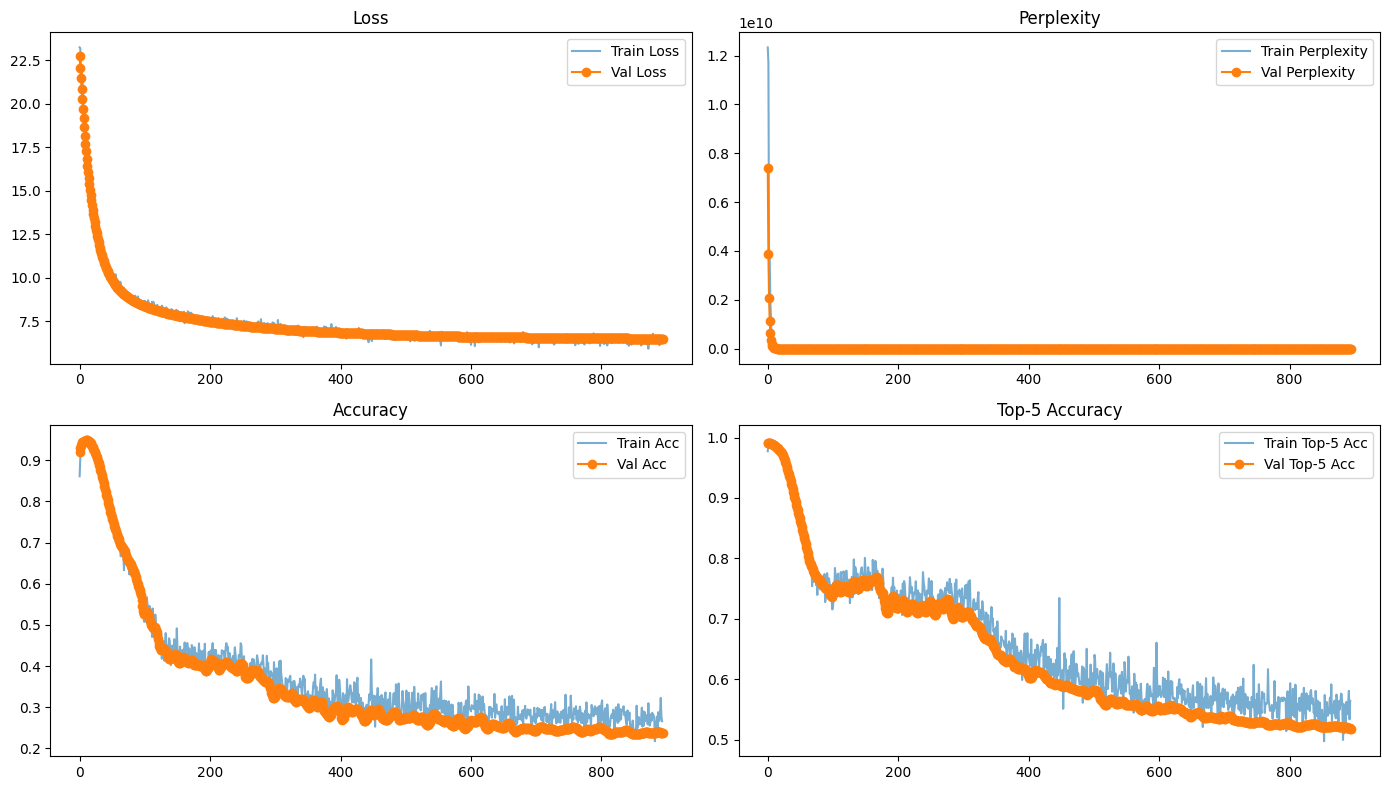

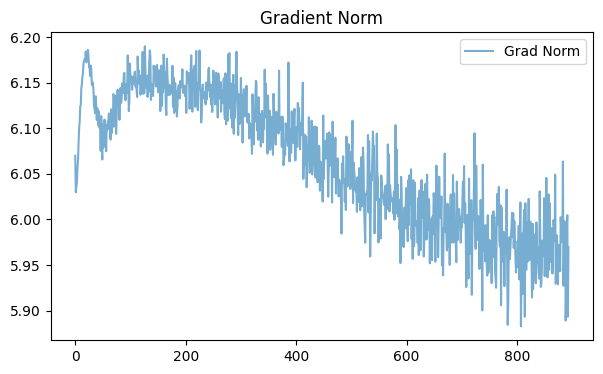

  Validation loss improved to 6.4838. Saving model checkpoint.
  Step: 894 | Batch: 1/149
    Train Loss: 6.5692 | Train PPL: 712.7736
    Train Acc: 0.3240 | Train Top-5: 0.6273
    Val Loss:   6.4837 | Val PPL:   654.4063
    Val Acc:    0.2375 | Val Top-5:   0.5173
    Grad Norm:  5.9945
  Step: 895 | Batch: 2/149
    Train Loss: 6.4324 | Train PPL: 621.6480
    Train Acc: 0.2441 | Train Top-5: 0.5333
    Val Loss:   6.4837 | Val PPL:   654.4159
    Val Acc:    0.2371 | Val Top-5:   0.5168
    Grad Norm:  5.9968
  Step: 896 | Batch: 3/149
    Train Loss: 6.4548 | Train PPL: 635.7451
    Train Acc: 0.2733 | Train Top-5: 0.5487
    Val Loss:   6.4837 | Val PPL:   654.4085
    Val Acc:    0.2370 | Val Top-5:   0.5164
    Grad Norm:  5.8531
  Step: 897 | Batch: 4/149
    Train Loss: 6.4837 | Train PPL: 654.3710
    Train Acc: 0.2523 | Train Top-5: 0.5329
    Val Loss:   6.4838 | Val PPL:   654.4254
    Val Acc:    0.2365 | Val Top-5:   0.5161
    Grad Norm:  5.9191
  Step: 898 | Batch: 

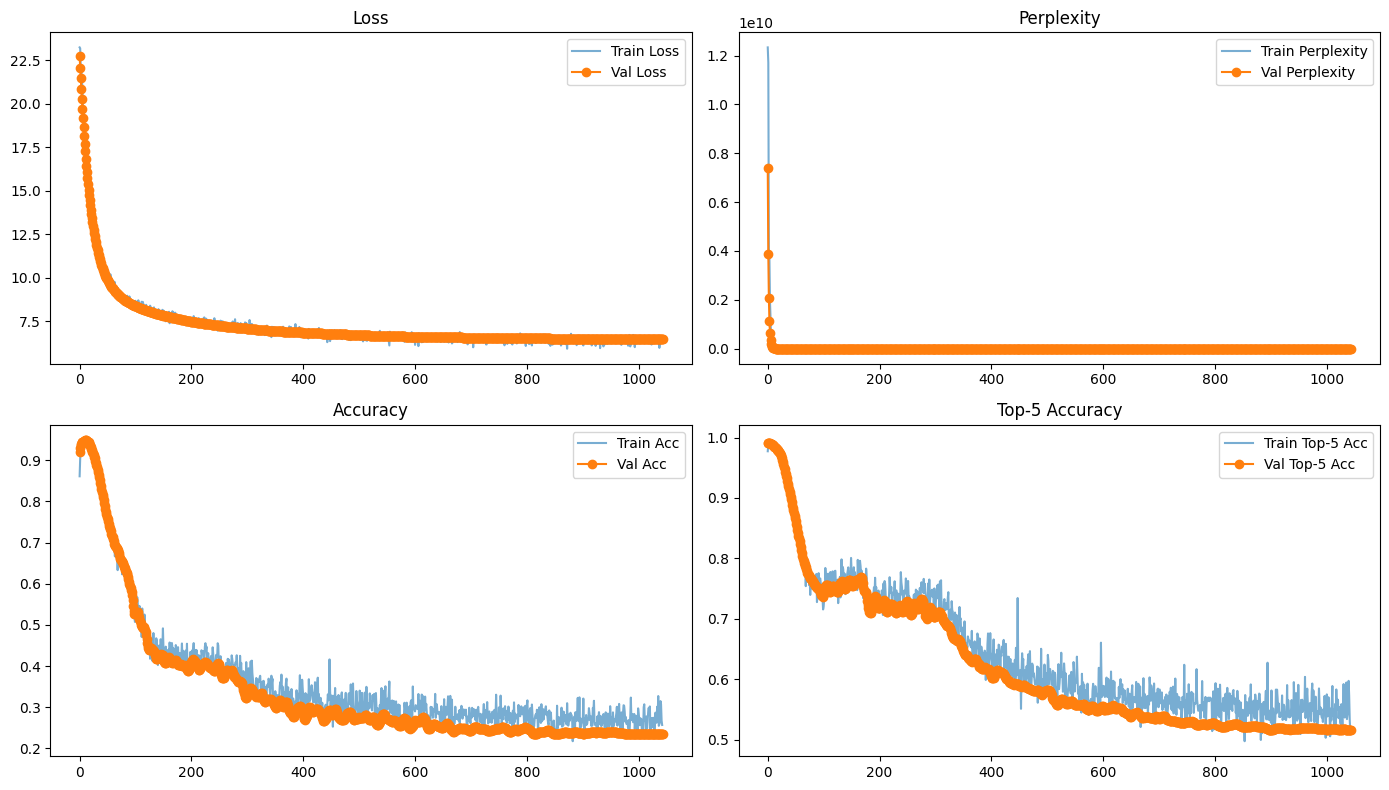

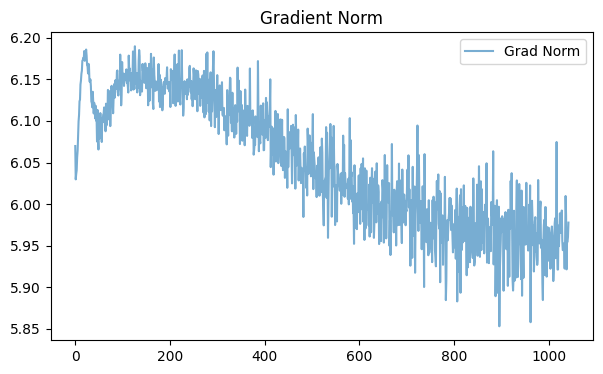

  Validation loss improved to 6.4696. Saving model checkpoint.
  Step: 1043 | Batch: 1/149
    Train Loss: 6.6061 | Train PPL: 739.5973
    Train Acc: 0.3090 | Train Top-5: 0.6269
    Val Loss:   6.4696 | Val PPL:   645.2287
    Val Acc:    0.2344 | Val Top-5:   0.5166
    Grad Norm:  5.9611
  Step: 1044 | Batch: 2/149
    Train Loss: 6.1519 | Train PPL: 469.6186
    Train Acc: 0.2766 | Train Top-5: 0.5651
    Val Loss:   6.4696 | Val PPL:   645.1967
    Val Acc:    0.2344 | Val Top-5:   0.5166
    Grad Norm:  5.9288
  Step: 1045 | Batch: 3/149
    Train Loss: 6.5575 | Train PPL: 704.4947
    Train Acc: 0.3060 | Train Top-5: 0.5918
    Val Loss:   6.4695 | Val PPL:   645.1755
    Val Acc:    0.2345 | Val Top-5:   0.5166
    Grad Norm:  5.9899
  Step: 1046 | Batch: 4/149
    Train Loss: 6.3313 | Train PPL: 561.8781
    Train Acc: 0.2773 | Train Top-5: 0.5395
    Val Loss:   6.4695 | Val PPL:   645.1403
    Val Acc:    0.2347 | Val Top-5:   0.5165
    Grad Norm:  5.9457
  Step: 1047 | Ba

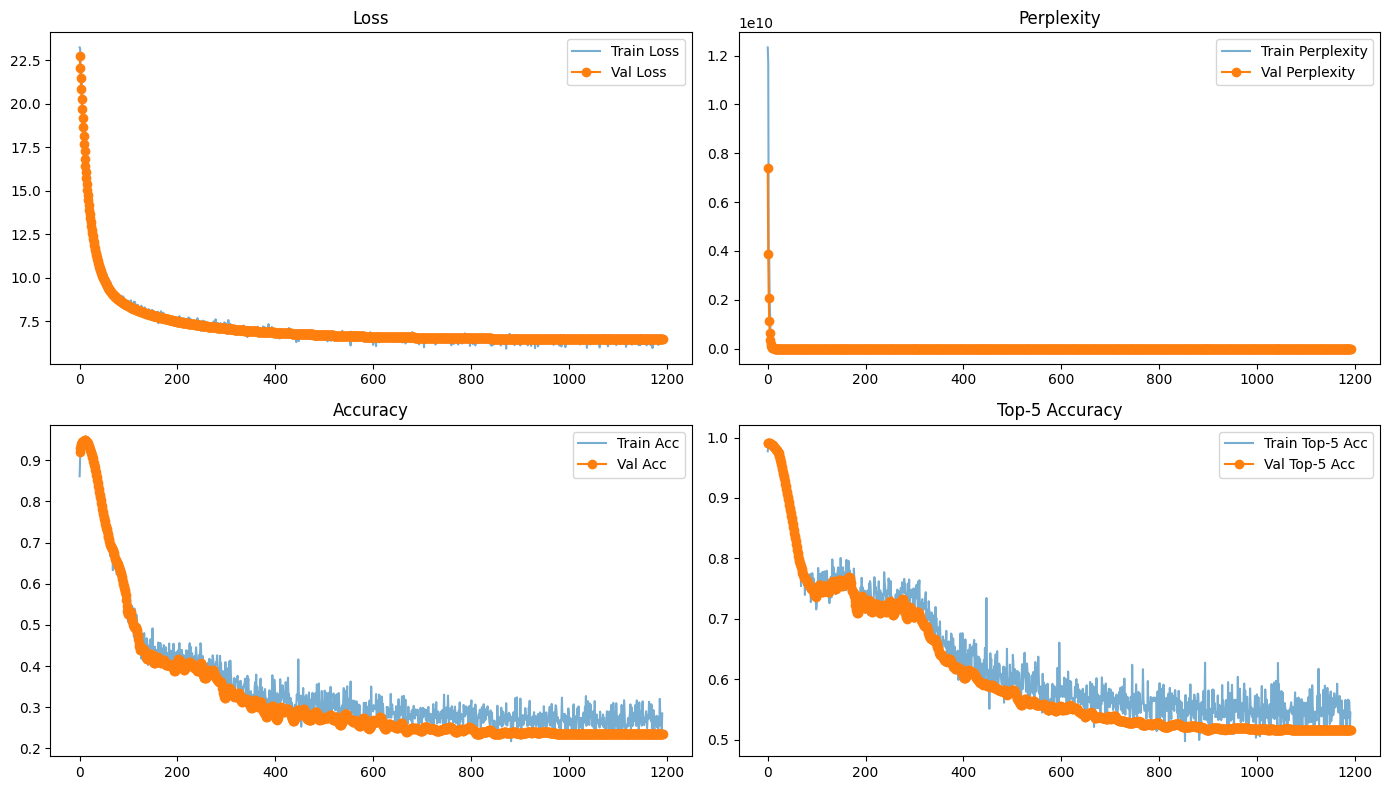

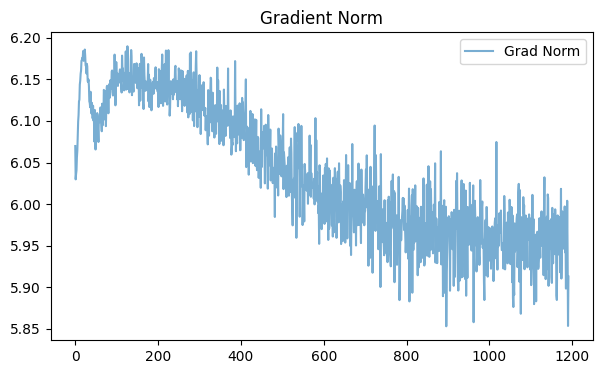

  Validation loss improved to 6.4674. Saving model checkpoint.
--- Finished training for causal ---
Finished training for causal model.
All training finished.


Wandb run finished.


In [6]:
# --- Тренировка с early stopping, чекпоинтами и графиками ---
def train(model, optimizer, scheduler, tag):
    best_val_loss = float('inf')
    patience = 0
    # Списки для хранения метрик для графиков в конце эпохи
    all_train_losses, all_val_losses = [], []
    all_train_perplexities, all_val_perplexities = [], []
    all_train_accs, all_val_accs = [], []
    all_train_top5, all_val_top5 = [], []
    all_grad_norms = []
    # Шаги, на которых была валидация (для оси X графиков)
    val_steps = [] 
    step = 0
    GRAD_CLIP_VALUE = 1.0 # Add gradient clipping value

    print(f"--- Starting training for {tag} ---")
    for epoch in range(EPOCHS):
        model.train()
        for i, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = input_ids.clone()
            labels[attention_mask == 0] = -100

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits.detach().cpu()

            optimizer.zero_grad()
            loss.backward()
            
            # --- Add Gradient Clipping ---
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VALUE)
            # --------------------------
            
            grad_norm = sum(p.grad.norm().item() for p in model.parameters() if p.grad is not None) # Calculate norm *after* clipping
            optimizer.step()
# update learning rate
            scheduler.step()

            # Сохраняем текущие метрики батча
            current_loss = loss.item()
            current_ppl = np.exp(current_loss)
            current_acc = accuracy(logits, labels.cpu(), attention_mask.cpu())
            current_top5 = top_k_accuracy(logits, labels.cpu(), attention_mask.cpu(), k=5)
            
            # Добавляем метрики обучения в общие списки
            all_train_losses.append(current_loss)
            all_train_perplexities.append(current_ppl)
            all_train_accs.append(current_acc)
            all_train_top5.append(current_top5)
            all_grad_norms.append(grad_norm)

            if step % LOG_INTERVAL == 0:
                val_loss, val_ppl, val_acc, val_top5_acc = evaluate(model, val_loader)
                
                # Добавляем метрики валидации в общие списки
                all_val_losses.append(val_loss)
                all_val_perplexities.append(val_ppl)
                all_val_accs.append(val_acc)
                all_val_top5.append(val_top5_acc)
                val_steps.append(step) # Сохраняем шаг валидации
                
                # Логирование в W&B (оставляем)
                wandb.log({f"loss_{tag}": current_loss,
                           f"perplexity_{tag}": current_ppl,
                           f"accuracy_{tag}": current_acc,
                           f"top5_accuracy_{tag}": current_top5,
                           f"grad_norm_{tag}": grad_norm, # Log the clipped grad norm
                           f"val_loss_{tag}": val_loss,
                           f"val_perplexity_{tag}": val_ppl,
                           f"val_accuracy_{tag}": val_acc,
                           f"val_top5_accuracy_{tag}": val_top5_acc,
                           "step": step})
                
                # Вывод метрик числами (КАЖДЫЕ LOG_INTERVAL шагов)
                print(f"  Step: {step} | Batch: {i+1}/{len(train_loader)}")
                print(f"    Train Loss: {current_loss:.4f} | Train PPL: {current_ppl:.4f}")
                print(f"    Train Acc: {current_acc:.4f} | Train Top-5: {current_top5:.4f}")
                print(f"    Val Loss:   {val_loss:.4f} | Val PPL:   {val_ppl:.4f}")
                print(f"    Val Acc:    {val_acc:.4f} | Val Top-5:   {val_top5_acc:.4f}")
                print(f"    Grad Norm:  {grad_norm:.4f}") # Print clipped grad norm

            step += 1
            
        # --- Конец Эпохи --- 
        # Валидация в конце эпохи (для early stopping и вывода)
        val_loss, val_ppl, val_acc, val_top5_acc = evaluate(model, val_loader)
        # Добавляем последние значения валидации, если эпоха не закончилась на шаге LOG_INTERVAL
        if step not in val_steps:
             all_val_losses.append(val_loss)
             all_val_perplexities.append(val_ppl)
             all_val_accs.append(val_acc)
             all_val_top5.append(val_top5_acc)
             val_steps.append(step)

        avg_epoch_train_loss = np.mean(all_train_losses[-len(train_loader):])  # Берем только последние значения за эпоху
        avg_epoch_train_ppl = np.exp(avg_epoch_train_loss)
        print(f"--- Epoch {epoch+1} Summary ---")
        print(f"  Avg Train Loss: {avg_epoch_train_loss:.4f} | Avg Train PPL: {avg_epoch_train_ppl:.4f}")
        print(f"  Val Loss:       {val_loss:.4f} | Val PPL:       {val_ppl:.4f}")
        print(f"  Val Accuracy:   {val_acc:.4f} | Val Top-5 Acc: {val_top5_acc:.4f}")
        
        # Строим графики В КОНЦЕ ЭПОХИ
        train_steps = list(range(step)) # Шаги для обучающих метрик
        fig, axs = plt.subplots(2, 2, figsize=(14,8))
        # Используем сохраненные списки метрик
        axs[0,0].plot(train_steps, all_train_losses, label='Train Loss', alpha=0.6)
        axs[0,0].plot(val_steps, all_val_losses, label='Val Loss', marker='o')
        axs[0,0].set_title('Loss')
        axs[0,0].legend()
        axs[0,1].plot(train_steps, all_train_perplexities, label='Train Perplexity', alpha=0.6)
        axs[0,1].plot(val_steps, all_val_perplexities, label='Val Perplexity', marker='o')
        axs[0,1].set_title('Perplexity')
        axs[0,1].legend()
        axs[1,0].plot(train_steps, all_train_accs, label='Train Acc', alpha=0.6)
        axs[1,0].plot(val_steps, all_val_accs, label='Val Acc', marker='o')
        axs[1,0].set_title('Accuracy')
        axs[1,0].legend()
        axs[1,1].plot(train_steps, all_train_top5, label='Train Top-5 Acc', alpha=0.6)
        axs[1,1].plot(val_steps, all_val_top5, label='Val Top-5 Acc', marker='o')
        axs[1,1].set_title('Top-5 Accuracy')
        axs[1,1].legend()
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(7,4))
        plt.plot(train_steps, all_grad_norms, label='Grad Norm', alpha=0.6)
        plt.title('Gradient Norm')
        plt.legend()
        plt.show()
        
        # Сохраняем чекпоинт эпохи (оставляем)
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f'{tag}_epoch{epoch}.pt'))
        
        # Early stopping (оставляем)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
            print(f"  Validation loss improved to {best_val_loss:.4f}. Saving model checkpoint.")
        else:
            patience += 1
            print(f"  Validation loss did not improve. Patience: {patience}/{EARLY_STOPPING_PATIENCE}")
            if patience >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping for {tag} at epoch {epoch+1}")
                break
                
    print(f"--- Finished training for {tag} ---")
    # Возвращаем собранные метрики, если они нужны для анализа после обучения
    results = {
        "train_losses": all_train_losses,
        "val_losses": all_val_losses,
        "train_perplexities": all_train_perplexities,
        "val_perplexities": all_val_perplexities,
        "train_accs": all_train_accs,
        "val_accs": all_val_accs,
        "train_top5": all_train_top5,
        "val_top5": all_val_top5,
        "grad_norms": all_grad_norms,
        "val_steps": val_steps,
        "total_steps": step
    }
    return results

# --- Восстановление чекпоинта (если есть) ---
# last_regular_ckpt = './checkpoints_gpt2_compare/regular_step172.pt'
# last_causal_ckpt = None

# if os.path.exists(last_regular_ckpt):
#     print(f"Loading regular_gpt2 weights from {last_regular_ckpt}")
#     regular_gpt2.load_state_dict(torch.load(last_regular_ckpt, map_location=DEVICE))
#     # Если вы сохраняли optimizer, можно добавить восстановление состояния оптимизатора
#     # optim_regular.load_state_dict(torch.load(last_regular_ckpt.replace('.pt', '_optim.pt')))

# if last_causal_ckpt and os.path.exists(last_causal_ckpt):
#     print(f"Loading causal_gpt2 weights from {last_causal_ckpt}")
#     causal_gpt2.load_state_dict(torch.load(last_causal_ckpt, map_location=DEVICE))
#     # optim_causal.load_state_dict(torch.load(last_causal_ckpt.replace('.pt', '_optim.pt')))

# Обучение обеих моделей
print("Starting training...")

print("Starting training for regular model...")
results_regular = train(regular_gpt2, optim_regular, scheduler_regular, tag="regular")
print("Finished training for regular model.")

print("Starting training for causal model...")
results_causal = train(causal_gpt2, optim_causal, scheduler_causal, tag="causal")
print("Finished training for causal model.")

print("All training finished.")

# Завершение W&B run
if wandb.run is not None:
    wandb.finish()
    print("Wandb run finished.")

# Next Steps for Testing Causal Embeddings
Чтобы убедиться в ценности каузальных эмбеддингов, попробуйте следующие подходы:

1. **Двухэтапная дообучение**
   - Фаза 1: зафиксируйте все параметры модели, кроме слоя эмбеддингов (`wte`), и обучайте только их.
   - Фаза 2: после сближения эмбеддингов, разморозьте остальные слои и продолжите дообучение всей модели.

2. **Различные скорости обучения**
   - Используйте меньший `learning_rate` для эмбеддингов и больший — для остальных слоев.
   - Подключите планировщик (`lr_scheduler`) с разогревом и затуханием.

3. **Регуляризация и нормализация**
   - Попробуйте увеличить `dropout_prob` в `CausalEmbeddingModel`.
   - Наложите градиентный клиппинг и L2-регуляризацию.

4. **Увеличение и разнообразие данных**
   - Добавьте больше примеров из валидационной части или других небольших корпусах.
   - Пробуйте разные длины `MAX_LEN` и стратегии `truncation`.

5. **Диагностика эмбеддингов**
   - Визуализируйте распределение эмбеддингов (TSNE/PCA).
   - Сравните косинусные сходства между семантически близкими токенами.

6. **Фиксация и сравнение**
   - Сохраняйте чекпоинты каждого шага и сравнивайте `perplexity` на валидации.
   - Логируйте метрики отдельно для фазы 1 и фазы 2.

# Анализ Attention Maps, Доверительных Интервалов и Эмбеддингов

В следующих ячейках:
1. Анализируем attention maps двух моделей (метрики и визуализации).
2. Строим доверительные интервалы для loss/perplexity/accuracy.
3. Визуализируем распределения эмбеддингов (TSNE/PCA).

## 1. Анализ Attention Maps: Метрики и Визуализации

- **Среднее и дисперсия attention по слоям/головам**
- **Сравнение sparsity (разреженности) attention**
- **Визуализация attention для отдельных примеров**
- **Cosine similarity между attention картами двух моделей**

In [7]:
def get_attention_maps(model, dataloader, num_batches=5):
    model.eval()
    attentions = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_batches:
                break
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
            # outputs.attentions: tuple of (num_layers, batch, num_heads, seq_len, seq_len)
            attentions.append([a.cpu().numpy() for a in outputs.attentions])
    # Stack: [num_batches, num_layers, batch, num_heads, seq_len, seq_len]
    # We'll concatenate along batch dimension
    attentions = [np.concatenate([att[layer] for att in attentions], axis=0) for layer in range(len(attentions[0]))]
    return attentions  # list of [total_batch, num_heads, seq_len, seq_len] per layer

# Получаем attention карты для обеих моделей (по небольшому количеству батчей)
attn_regular = get_attention_maps(regular_gpt2, val_loader, num_batches=5)
attn_causal = get_attention_maps(causal_gpt2, val_loader, num_batches=5)

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


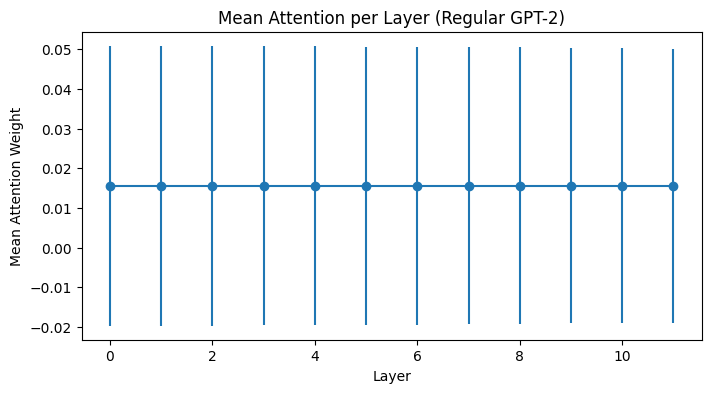

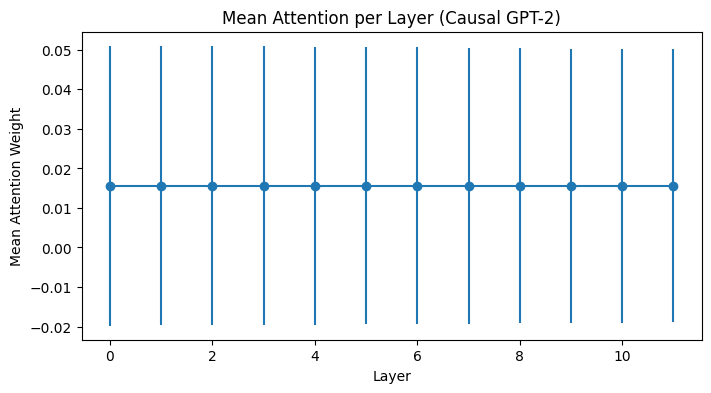

In [8]:
# Пример: среднее значение attention по слоям и головам
def plot_attention_stats(attn_maps, model_name):
    num_layers = len(attn_maps)
    means = [np.mean(layer) for layer in attn_maps]
    stds = [np.std(layer) for layer in attn_maps]
    plt.figure(figsize=(8,4))
    plt.errorbar(range(num_layers), means, yerr=stds, fmt='-o')
    plt.title(f"Mean Attention per Layer ({model_name})")
    plt.xlabel("Layer")
    plt.ylabel("Mean Attention Weight")
    plt.show()

plot_attention_stats(attn_regular, "Regular GPT-2")
plot_attention_stats(attn_causal, "Causal GPT-2")

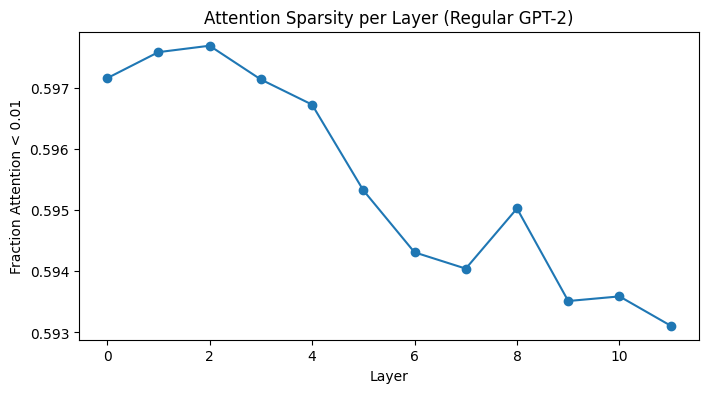

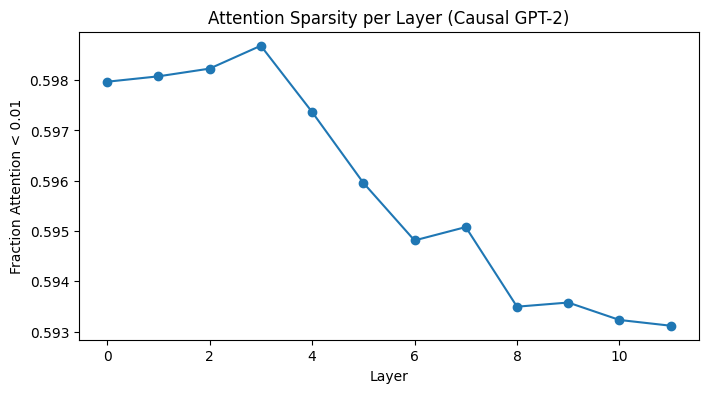

In [9]:
# Пример: разреженность attention (доля весов < 0.01)
def plot_attention_sparsity(attn_maps, model_name, threshold=0.01):
    num_layers = len(attn_maps)
    sparsity = [np.mean(layer < threshold) for layer in attn_maps]
    plt.figure(figsize=(8,4))
    plt.plot(range(num_layers), sparsity, '-o')
    plt.title(f"Attention Sparsity per Layer ({model_name})")
    plt.xlabel("Layer")
    plt.ylabel(f"Fraction Attention < {threshold}")
    plt.show()

plot_attention_sparsity(attn_regular, "Regular GPT-2")
plot_attention_sparsity(attn_causal, "Causal GPT-2")

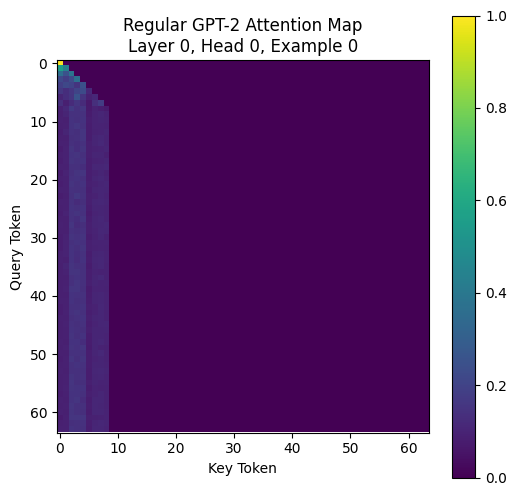

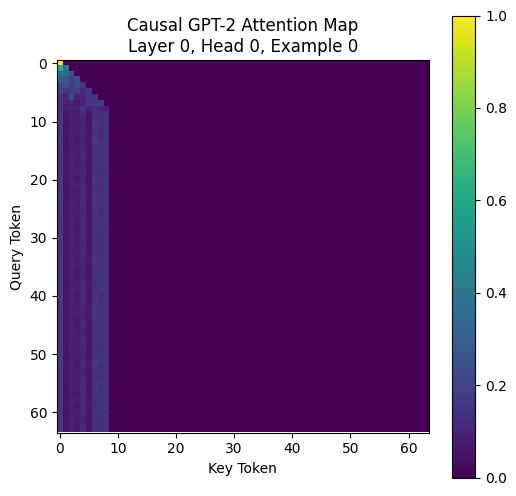

In [10]:
# Визуализация attention карты для одного примера
def show_attention_map(attn_maps, layer=0, head=0, token_idx=0, model_name="Model"):
    attn = attn_maps[layer][token_idx, head]
    plt.figure(figsize=(6,6))
    plt.imshow(attn, cmap='viridis')
    plt.title(f"{model_name} Attention Map\nLayer {layer}, Head {head}, Example {token_idx}")
    plt.xlabel("Key Token")
    plt.ylabel("Query Token")
    plt.colorbar()
    plt.show()

show_attention_map(attn_regular, layer=0, head=0, token_idx=0, model_name="Regular GPT-2")
show_attention_map(attn_causal, layer=0, head=0, token_idx=0, model_name="Causal GPT-2")

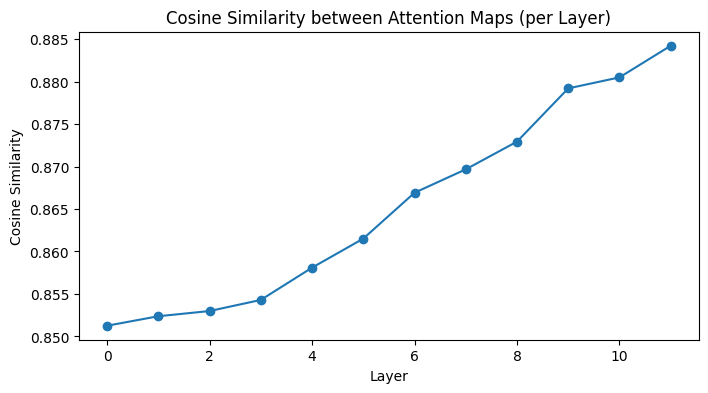

In [11]:
# Сравнение attention карт: косинусное сходство между средними attention по слоям
from sklearn.metrics.pairwise import cosine_similarity

def compare_attention_cosine(attn1, attn2):
    # Flatten per layer: [batch, head, seq, seq] -> [batch*head, seq*seq]
    sims = []
    for l in range(len(attn1)):
        a1 = attn1[l].reshape(-1, attn1[l].shape[-2]*attn1[l].shape[-1])
        a2 = attn2[l].reshape(-1, attn2[l].shape[-2]*attn2[l].shape[-1])
        sim = cosine_similarity(a1, a2).mean()
        sims.append(sim)
    plt.figure(figsize=(8,4))
    plt.plot(range(len(sims)), sims, '-o')
    plt.title("Cosine Similarity between Attention Maps (per Layer)")
    plt.xlabel("Layer")
    plt.ylabel("Cosine Similarity")
    plt.show()

compare_attention_cosine(attn_regular, attn_causal)

## 2. Доверительные интервалы для Loss, Perplexity, Accuracy

- Используем бутстрэп или стандартную ошибку для построения доверительных интервалов.
- Визуализируем интервалы на графиках.

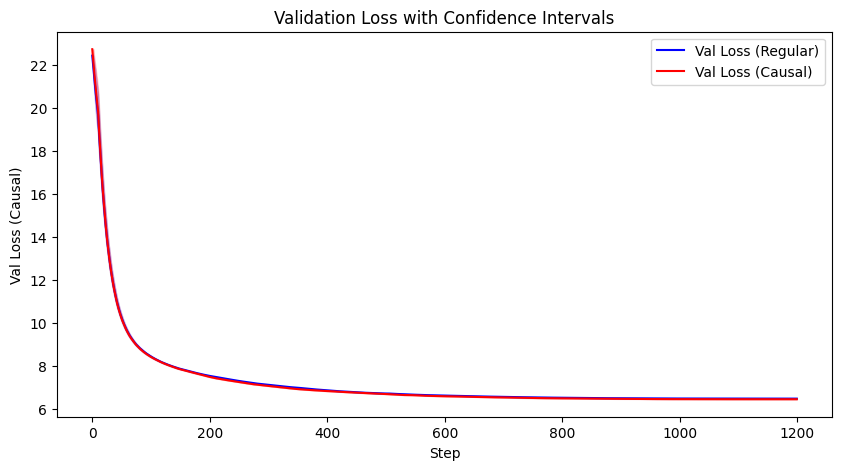

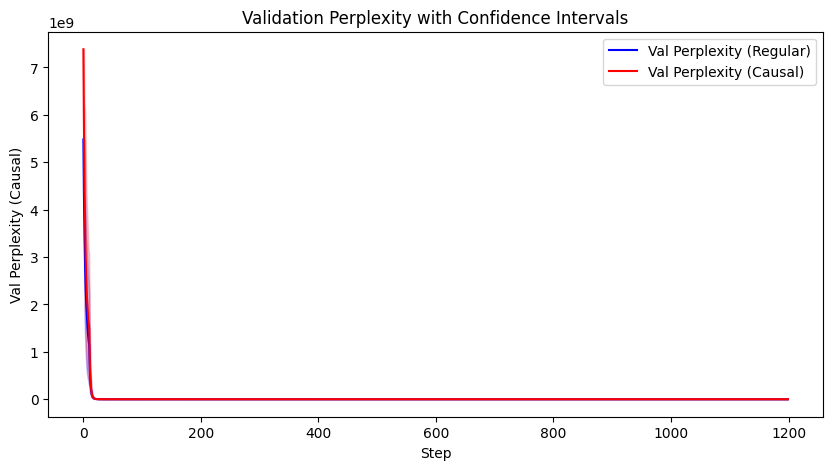

In [12]:
import scipy.stats as st

def plot_with_confidence_intervals(values, label, color=None):
    values = np.array(values)
    steps = np.arange(len(values))
    # Бутстрэп для доверительных интервалов
    means = []
    cis_low = []
    cis_high = []
    n_boot = 1000
    for i in range(len(values)):
        samples = np.random.choice(values[max(0, i-10):i+1], size=(n_boot, min(10, i+1)), replace=True)
        sample_means = samples.mean(axis=1)
        means.append(np.mean(sample_means))
        ci = np.percentile(sample_means, [2.5, 97.5])
        cis_low.append(ci[0])
        cis_high.append(ci[1])
    plt.fill_between(steps, cis_low, cis_high, alpha=0.2, color=color)
    plt.plot(steps, means, label=label, color=color)
    plt.xlabel("Step")
    plt.ylabel(label)
    plt.legend()

plt.figure(figsize=(10,5))
plot_with_confidence_intervals(results_regular['val_losses'], "Val Loss (Regular)", color='blue')
plot_with_confidence_intervals(results_causal['val_losses'], "Val Loss (Causal)", color='red')
plt.title("Validation Loss with Confidence Intervals")
plt.show()

plt.figure(figsize=(10,5))
plot_with_confidence_intervals(results_regular['val_perplexities'], "Val Perplexity (Regular)", color='blue')
plot_with_confidence_intervals(results_causal['val_perplexities'], "Val Perplexity (Causal)", color='red')
plt.title("Validation Perplexity with Confidence Intervals")
plt.show()

## 3. Визуализация распределения эмбеддингов (TSNE/PCA)

- Получаем эмбеддинги токенов для обеих моделей.
- Строим TSNE/PCA и сравниваем распределения.

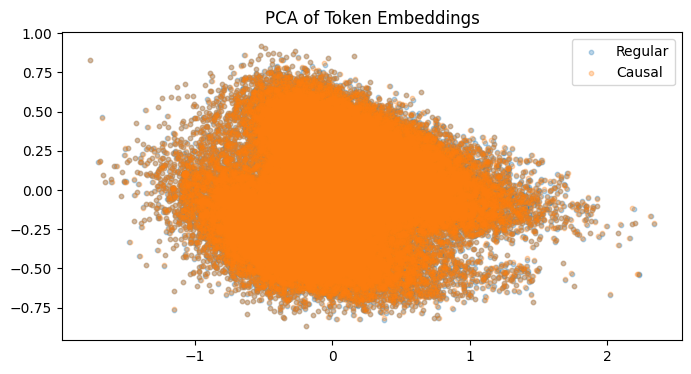

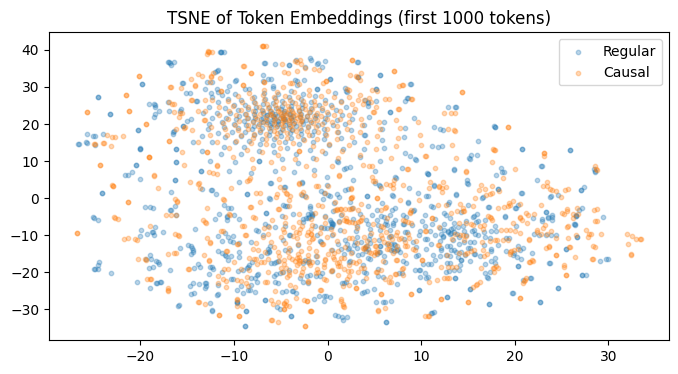

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def get_token_embeddings(model):
    # Возвращает веса embedding слоя (wte)
    return model.transformer.wte.weight.detach().cpu().numpy()

embeds_regular = get_token_embeddings(regular_gpt2)
embeds_causal = get_token_embeddings(causal_gpt2)

# PCA
pca = PCA(n_components=2)
pca_reg = pca.fit_transform(embeds_regular)
pca_causal = pca.fit_transform(embeds_causal)

plt.figure(figsize=(8,4))
plt.scatter(pca_reg[:,0], pca_reg[:,1], alpha=0.3, label='Regular', s=10)
plt.scatter(pca_causal[:,0], pca_causal[:,1], alpha=0.3, label='Causal', s=10)
plt.title("PCA of Token Embeddings")
plt.legend()
plt.show()

# TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_reg = tsne.fit_transform(embeds_regular[:1000])
tsne_causal = tsne.fit_transform(embeds_causal[:1000])

plt.figure(figsize=(8,4))
plt.scatter(tsne_reg[:,0], tsne_reg[:,1], alpha=0.3, label='Regular', s=10)
plt.scatter(tsne_causal[:,0], tsne_causal[:,1], alpha=0.3, label='Causal', s=10)
plt.title("TSNE of Token Embeddings (first 1000 tokens)")
plt.legend()
plt.show()